Fit model to data. 

Add an extra event that was originally not analysed, and removing two that were reclassified:

Add: HsaEX1046522 from the ABI2 gene and the PSI values in GFP, CONT, LOW, MID, HIGH are 0, 2.28, 20.47, 74.85, 83.45.

Remove:
remove the events HsaEX0051111 and HsaEX1003606 from this category (I reclassified them as NonResponding)



In [23]:
import deap
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
from functools import partial
import random, sys

import sympy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import seaborn as sns
import copy

sys.path.append("/Users/rosamartinezcorral/OneDrive - CRG - Centre de Regulacio Genomica/papers/github_repos/SRRM4_MapSy_2024")
import auxfuncs_fitting
from collections import OrderedDict

In [24]:
remove=["HsaEX0051111", "HsaEX1003606"]

Even if I only want to fit to a few subcategories here, load everything in case we want to change this.

# Get the data (minigene library)

In [25]:
#for each subcategory, I want a dataframe of the LS, with 4 columns: GFP, LOW, MID, HIGH, and the HS, with 4 columns: GFP, LOW, MID, HIGH
#So if we have n subcategories, we end up with 2*n dataframes

categories_fit_HSLS=['WT','U1cons_a','U1cons_b','U6cons','GTtoGC5ss', 'BP_stg1', 'BP_weak3', 'Py-stg3','Py-weak3','BP_stg1;Py-stg3','BP_weak3;Py-weak3','BP_stg1;Py-stg3;U1cons','-ESS2-3','-ESE2-5']


dfind=pd.read_csv("./2024_07_04_HSLStofit.csv",sep="\t",index_col=0)
display(dfind.head())

VARIANT gene_or_species         event mutation  \
0    ABI1-HsaEX0000641-U1cons            ABI1  HsaEX0000641  -U1cons   
1    ABI1-HsaEX0000641-U6cons            ABI1  HsaEX0000641  -U6cons   
2        ABI1-HsaEX0000641-WT            ABI1  HsaEX0000641      -WT   
3  ACVR2A-HsaEX0002213-U1cons          ACVR2A  HsaEX0002213  -U1cons   
4  ACVR2A-HsaEX0002213-U6cons          ACVR2A  HsaEX0002213  -U6cons   

     Subcat    GFP    LOW    MID   HIGH final_tier  
0  U1cons_a   9.40   8.64  43.48  95.09         HS  
1    U6cons  16.24  16.11  45.80  97.37         HS  
2        WT   2.70   5.39  32.39  92.30         HS  
3  U1cons_a   3.79   4.99  38.16  92.12         LS  
4    U6cons   5.13   7.89  40.64  95.18         LS

In [26]:
dfind[dfind["event"].isin(remove)]

Empty DataFrame
Columns: [VARIANT, gene_or_species, event, mutation, Subcat, GFP, LOW, MID, HIGH, final_tier]
Index: []

In [27]:
np.unique(sorted(dfind["event"].values))

array(['HsaEX0000641', 'HsaEX0002213', 'HsaEX0012545', 'HsaEX0015276',
       'HsaEX0015478', 'HsaEX0016976', 'HsaEX0018777', 'HsaEX0026467',
       'HsaEX0027672', 'HsaEX0032608', 'HsaEX0034483', 'HsaEX0035450',
       'HsaEX0037213', 'HsaEX0038690', 'HsaEX0038702', 'HsaEX0039034',
       'HsaEX0040386', 'HsaEX0043752', 'HsaEX0044638', 'HsaEX0047035',
       'HsaEX0048492', 'HsaEX0049811', 'HsaEX0051317', 'HsaEX0057701',
       'HsaEX0058030', 'HsaEX0063374', 'HsaEX0063412', 'HsaEX0064198',
       'HsaEX0067208', 'HsaEX1019114', 'HsaEX1026556'], dtype='<U12')

In [28]:
desired_order=categories_fit_HSLS

inputcols=["GFP","LOW","MID","HIGH"]
individual_subdf_minigene=[]
for group in desired_order:
    if group=="WT":
        namecat="WTminigene"
    else:
        namecat=group
    for subgroup in ["LS","HS"]:
        subdf=dfind[(dfind["Subcat"]==group)&(dfind["final_tier"]==subgroup)].copy()
        #in case each event is repeated multiple times, average
        subdf=subdf.groupby(["event"])[inputcols].mean()
        newcolnames=[namecat+"-"+subgroup+":"+x for x in inputcols]
        subdf.columns=newcolnames
        display(subdf.head())
        individual_subdf_minigene.append(subdf)
        
        

WTminigene-LS:GFP  WTminigene-LS:LOW  WTminigene-LS:MID  \
event                                                                   
HsaEX0002213             2.3000             9.5675            52.7325   
HsaEX0015276             0.4075             2.1975            32.9325   
HsaEX0015478             1.1850             0.8950             8.1450   
HsaEX0027672             0.0200             1.0500            12.2000   
HsaEX0032608             0.0175             0.1825             6.2050   

              WTminigene-LS:HIGH  
event                             
HsaEX0002213             95.7950  
HsaEX0015276             84.7300  
HsaEX0015478             59.3175  
HsaEX0027672             71.7500  
HsaEX0032608             52.5400

WTminigene-HS:GFP  WTminigene-HS:LOW  WTminigene-HS:MID  \
event                                                                   
HsaEX0000641             2.8450             7.2850            43.1275   
HsaEX0012545             0.2025             2.1975            29.4400   
HsaEX0016976             1.2525             7.2550            42.1825   
HsaEX0018777             3.1775             4.6425            36.6000   
HsaEX0026467             8.7350            18.3425            46.1025   

              WTminigene-HS:HIGH  
event                             
HsaEX0000641             93.3225  
HsaEX0012545             87.4275  
HsaEX0016976             90.7075  
HsaEX0018777             89.6625  
HsaEX0026467             91.1475

U1cons_a-LS:GFP  U1cons_a-LS:LOW  U1cons_a-LS:MID  \
event                                                             
HsaEX0002213             3.79             4.99            38.16   
HsaEX0015276             0.84             2.14            31.80   
HsaEX0015478             5.28             5.62            32.55   
HsaEX0027672              NaN              NaN              NaN   
HsaEX0032608             0.13             0.13             7.33   

              U1cons_a-LS:HIGH  
event                           
HsaEX0002213             92.12  
HsaEX0015276             92.84  
HsaEX0015478             94.89  
HsaEX0027672               NaN  
HsaEX0032608             71.18

U1cons_a-HS:GFP  U1cons_a-HS:LOW  U1cons_a-HS:MID  \
event                                                             
HsaEX0000641             9.40             8.64            43.48   
HsaEX0012545             7.32            27.58            61.52   
HsaEX0016976            48.36            71.52            81.26   
HsaEX0018777             8.11            11.71            42.31   
HsaEX0026467            43.11            62.24            74.02   

              U1cons_a-HS:HIGH  
event                           
HsaEX0000641             95.09  
HsaEX0012545             96.94  
HsaEX0016976             96.57  
HsaEX0018777             93.28  
HsaEX0026467             97.32

U1cons_b-LS:GFP  U1cons_b-LS:LOW  U1cons_b-LS:MID  \
event                                                             
HsaEX0002213             8.28            30.54            72.71   
HsaEX0015276             1.37             7.13            53.45   
HsaEX0015478            11.71            15.39            61.78   
HsaEX0027672            27.00            39.88            73.60   
HsaEX0032608             0.19             0.83            14.32   

              U1cons_b-LS:HIGH  
event                           
HsaEX0002213             96.51  
HsaEX0015276             94.62  
HsaEX0015478             96.29  
HsaEX0027672             97.19  
HsaEX0032608             68.47

U1cons_b-HS:GFP  U1cons_b-HS:LOW  U1cons_b-HS:MID  \
event                                                             
HsaEX0000641             8.81            27.22            69.35   
HsaEX0012545             8.83            46.25            78.80   
HsaEX0016976            64.95            85.86            92.84   
HsaEX0018777            27.10            42.23            74.04   
HsaEX0026467             9.03            21.08            51.68   

              U1cons_b-HS:HIGH  
event                           
HsaEX0000641             95.99  
HsaEX0012545             97.84  
HsaEX0016976             98.16  
HsaEX0018777             96.52  
HsaEX0026467             90.45

U6cons-LS:GFP  U6cons-LS:LOW  U6cons-LS:MID  U6cons-LS:HIGH
event                                                                    
HsaEX0002213          6.480         17.345         54.890          96.585
HsaEX0015276          1.190          4.140         40.250          93.170
HsaEX0015478          7.025         10.000         46.760          94.790
HsaEX0027672          0.585          1.945         24.640          84.915
HsaEX0032608          0.000          0.535         11.635          71.845

U6cons-HS:GFP  U6cons-HS:LOW  U6cons-HS:MID  U6cons-HS:HIGH
event                                                                    
HsaEX0000641         16.100          23.02         56.565          96.850
HsaEX0012545          0.170           3.54         36.910          87.180
HsaEX0016976         64.475          82.40         91.300          97.475
HsaEX0018777         11.215          15.80         53.495          95.265
HsaEX0026467         52.460          70.56         85.040          97.140

GTtoGC5ss-LS:GFP  GTtoGC5ss-LS:LOW  GTtoGC5ss-LS:MID  \
event                                                                
HsaEX0002213               0.0               0.0               0.0   
HsaEX0015276               0.0               0.0               0.0   
HsaEX0015478               0.0               0.0               0.0   
HsaEX0027672               0.0               0.0               0.0   
HsaEX0032608               0.0               0.0               0.0   

              GTtoGC5ss-LS:HIGH  
event                            
HsaEX0002213               0.39  
HsaEX0015276               0.00  
HsaEX0015478               0.16  
HsaEX0027672               0.00  
HsaEX0032608               0.18

GTtoGC5ss-HS:GFP  GTtoGC5ss-HS:LOW  GTtoGC5ss-HS:MID  \
event                                                                
HsaEX0000641              0.00              0.00              0.00   
HsaEX0012545              0.00              0.68              1.47   
HsaEX0016976              0.00              0.00              0.19   
HsaEX0018777              0.00              0.00              0.13   
HsaEX0026467             22.73             22.08             26.63   

              GTtoGC5ss-HS:HIGH  
event                            
HsaEX0000641               0.00  
HsaEX0012545               5.97  
HsaEX0016976               0.20  
HsaEX0018777               0.00  
HsaEX0026467              35.24

BP_stg1-LS:GFP  BP_stg1-LS:LOW  BP_stg1-LS:MID  BP_stg1-LS:HIGH
event                                                                        
HsaEX0002213           33.07           63.93           85.33            98.59
HsaEX0015276            0.29            6.14           45.52            90.66
HsaEX0015478            1.43            0.77            7.70            50.00
HsaEX0027672            2.27            2.77           40.41            85.33
HsaEX0032608            0.40            2.79           36.18            89.88

BP_stg1-HS:GFP  BP_stg1-HS:LOW  BP_stg1-HS:MID  BP_stg1-HS:HIGH
event                                                                        
HsaEX0000641           13.56           32.80           68.88            95.81
HsaEX0012545            0.26            2.97           31.76            82.80
HsaEX0016976           63.03           81.51           90.89            98.01
HsaEX0018777           41.61           43.97           69.75            94.67
HsaEX0026467           24.83           39.83           64.65            94.19

BP_weak3-LS:GFP  BP_weak3-LS:LOW  BP_weak3-LS:MID  \
event                                                             
HsaEX0002213             1.79             3.48            20.49   
HsaEX0015276             2.76             0.60             2.91   
HsaEX0015478             0.00             0.00             0.00   
HsaEX0027672             0.00             0.27             4.79   
HsaEX0032608             0.00             0.00             0.09   

              BP_weak3-LS:HIGH  
event                           
HsaEX0002213             71.07  
HsaEX0015276             19.96  
HsaEX0015478              0.00  
HsaEX0027672             18.63  
HsaEX0032608              0.83

BP_weak3-HS:GFP  BP_weak3-HS:LOW  BP_weak3-HS:MID  \
event                                                             
HsaEX0000641             0.00             0.11             0.58   
HsaEX0012545             0.13             1.38            18.80   
HsaEX0016976             0.00             0.60            15.52   
HsaEX0018777             0.28             2.09             3.34   
HsaEX0026467             0.14             0.58             1.05   

              BP_weak3-HS:HIGH  
event                           
HsaEX0000641              5.15  
HsaEX0012545             64.45  
HsaEX0016976             53.06  
HsaEX0018777             10.70  
HsaEX0026467              5.61

Py-stg3-LS:GFP  Py-stg3-LS:LOW  Py-stg3-LS:MID  Py-stg3-LS:HIGH
event                                                                        
HsaEX0002213           51.18           79.18           92.22            98.69
HsaEX0015276           11.83           54.72           79.57            98.26
HsaEX0015478           67.31           74.44           84.25            96.66
HsaEX0027672            1.20            1.79           27.37            79.02
HsaEX0032608            0.04            6.55           46.83            92.93

Py-stg3-HS:GFP  Py-stg3-HS:LOW  Py-stg3-HS:MID  Py-stg3-HS:HIGH
event                                                                        
HsaEX0000641           30.79           63.86           85.52            97.84
HsaEX0012545            9.01           28.85           62.05            93.81
HsaEX0016976           12.02           33.58           66.47            95.04
HsaEX0018777           24.03           48.87           76.16            97.25
HsaEX0026467           54.49           69.15           79.55            95.26

Py-weak3-LS:GFP  Py-weak3-LS:LOW  Py-weak3-LS:MID  \
event                                                             
HsaEX0002213              0.0              0.0              0.0   
HsaEX0015276              0.0              0.0              0.0   
HsaEX0015478              0.0              0.0              0.0   
HsaEX0027672              0.0              0.0              0.0   
HsaEX0032608              0.0              0.0              0.0   

              Py-weak3-LS:HIGH  
event                           
HsaEX0002213               0.0  
HsaEX0015276               0.0  
HsaEX0015478               0.0  
HsaEX0027672               0.0  
HsaEX0032608               0.0

Py-weak3-HS:GFP  Py-weak3-HS:LOW  Py-weak3-HS:MID  \
event                                                             
HsaEX0000641             0.00             0.00             0.00   
HsaEX0012545             0.00             0.06             0.89   
HsaEX0016976             0.00             0.00             0.00   
HsaEX0018777             0.00             0.00             0.27   
HsaEX0026467             0.11             0.18             0.28   

              Py-weak3-HS:HIGH  
event                           
HsaEX0000641              0.00  
HsaEX0012545              3.36  
HsaEX0016976              0.00  
HsaEX0018777              1.45  
HsaEX0026467              0.29

BP_stg1;Py-stg3-LS:GFP  BP_stg1;Py-stg3-LS:LOW  \
event                                                          
HsaEX0002213                   94.37                   97.54   
HsaEX0015276                   15.12                   61.30   
HsaEX0015478                   67.31                   74.44   
HsaEX0027672                    7.05                   22.42   
HsaEX0032608                    6.76                   34.96   

              BP_stg1;Py-stg3-LS:MID  BP_stg1;Py-stg3-LS:HIGH  
event                                                          
HsaEX0002213                   98.20                    99.05  
HsaEX0015276                   81.50                    98.13  
HsaEX0015478                   84.25                    96.66  
HsaEX0027672                   62.76                    95.02  
HsaEX0032608                   67.27                    96.18

BP_stg1;Py-stg3-HS:GFP  BP_stg1;Py-stg3-HS:LOW  \
event                                                          
HsaEX0000641                   74.24                   88.15   
HsaEX0012545                    4.97                   19.63   
HsaEX0016976                   88.76                   94.43   
HsaEX0018777                   79.70                   82.72   
HsaEX0026467                   80.98                   86.37   

              BP_stg1;Py-stg3-HS:MID  BP_stg1;Py-stg3-HS:HIGH  
event                                                          
HsaEX0000641                   93.94                    98.71  
HsaEX0012545                   54.98                    90.83  
HsaEX0016976                   97.71                    97.72  
HsaEX0018777                   90.28                    97.31  
HsaEX0026467                   91.41                    97.75

BP_weak3;Py-weak3-LS:GFP  BP_weak3;Py-weak3-LS:LOW  \
event                                                              
HsaEX0002213                       0.0                      0.00   
HsaEX0015276                       0.0                      0.23   
HsaEX0015478                       0.0                      0.00   
HsaEX0027672                       0.0                      0.00   
HsaEX0032608                       0.0                      0.00   

              BP_weak3;Py-weak3-LS:MID  BP_weak3;Py-weak3-LS:HIGH  
event                                                              
HsaEX0002213                       0.0                       0.00  
HsaEX0015276                       0.0                       0.36  
HsaEX0015478                       0.0                       0.00  
HsaEX0027672                       0.0                       0.00  
HsaEX0032608                       0.0                       0.00

BP_weak3;Py-weak3-HS:GFP  BP_weak3;Py-weak3-HS:LOW  \
event                                                              
HsaEX0000641                      0.00                      0.00   
HsaEX0012545                      0.00                      0.00   
HsaEX0016976                      0.00                      0.19   
HsaEX0018777                      0.00                      0.00   
HsaEX0026467                      0.18                      0.00   

              BP_weak3;Py-weak3-HS:MID  BP_weak3;Py-weak3-HS:HIGH  
event                                                              
HsaEX0000641                      0.18                       0.00  
HsaEX0012545                      0.41                       1.98  
HsaEX0016976                      0.77                       0.00  
HsaEX0018777                      0.00                       0.00  
HsaEX0026467                      0.72                       0.00

BP_stg1;Py-stg3;U1cons-LS:GFP  BP_stg1;Py-stg3;U1cons-LS:LOW  \
event                                                                        
HsaEX0002213                          98.02                          98.82   
HsaEX0015276                          45.50                          80.70   
HsaEX0015478                          95.91                          98.04   
HsaEX0027672                          91.16                          93.45   
HsaEX0032608                          38.81                          74.50   

              BP_stg1;Py-stg3;U1cons-LS:MID  BP_stg1;Py-stg3;U1cons-LS:HIGH  
event                                                                        
HsaEX0002213                          98.72                           99.38  
HsaEX0015276                          92.49                           98.48  
HsaEX0015478                          98.79                           99.62  
HsaEX0027672                          97.30                           98.76  
HsaEX0032608                          88.10                           97.49

BP_stg1;Py-stg3;U1cons-HS:GFP  BP_stg1;Py-stg3;U1cons-HS:LOW  \
event                                                                        
HsaEX0000641                          90.03                          96.56   
HsaEX0012545                          84.38                          93.97   
HsaEX0016976                          98.27                          99.05   
HsaEX0018777                          96.46                          97.69   
HsaEX0026467                          80.98                          86.37   

              BP_stg1;Py-stg3;U1cons-HS:MID  BP_stg1;Py-stg3;U1cons-HS:HIGH  
event                                                                        
HsaEX0000641                          97.73                           98.79  
HsaEX0012545                          96.80                           98.91  
HsaEX0016976                          99.32                           99.50  
HsaEX0018777                          98.71                           99.23  
HsaEX0026467                          91.41                           97.75

-ESS2-3-LS:GFP  -ESS2-3-LS:LOW  -ESS2-3-LS:MID  -ESS2-3-LS:HIGH
event                                                                        
HsaEX0002213            0.18            2.52           26.94            82.91
HsaEX0015276            0.65            0.00            6.70            33.14
HsaEX0015478            0.08            0.00            0.13             0.96
HsaEX0027672            0.00            0.00            1.37             4.24
HsaEX0032608            0.00            0.00            0.35             3.48

-ESS2-3-HS:GFP  -ESS2-3-HS:LOW  -ESS2-3-HS:MID  -ESS2-3-HS:HIGH
event                                                                        
HsaEX0000641            0.46            3.47           32.72            83.34
HsaEX0012545            0.00            1.66           17.75            67.01
HsaEX0016976            0.00            0.00            0.10             0.16
HsaEX0018777            0.09            0.05            1.29             7.83
HsaEX0026467           28.21           34.53           60.34            92.23

-ESE2-5-LS:GFP  -ESE2-5-LS:LOW  -ESE2-5-LS:MID  -ESE2-5-LS:HIGH
event                                                                        
HsaEX0002213           29.44           35.67           65.35            94.10
HsaEX0015276            8.71           28.22           66.96            96.01
HsaEX0015478           35.68           47.68           71.09            96.78
HsaEX0027672            0.00            0.00           27.84            66.67
HsaEX0032608            0.00            2.77           42.74            92.74

-ESE2-5-HS:GFP  -ESE2-5-HS:LOW  -ESE2-5-HS:MID  -ESE2-5-HS:HIGH
event                                                                        
HsaEX0000641           64.58           91.01           96.67            98.50
HsaEX0012545            6.25           31.65           70.86            97.70
HsaEX0016976           14.96           28.35           65.87            94.16
HsaEX0018777           58.46           69.76           81.61            97.42
HsaEX0026467           73.33           86.97           89.31            88.69

(28, 4)


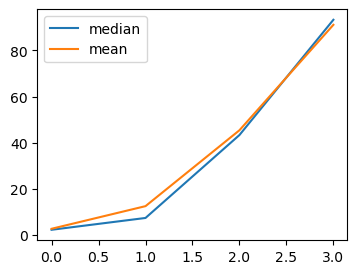

In [7]:
mediandata_minigene=np.asarray([np.nanmedian(x.values,axis=0) for x in individual_subdf_minigene]) #WT-minigene-LS, WT-minigene-HS, Py-weak1-LS,...
print(mediandata_minigene.shape)

meandata_minigene=np.asarray([np.nanmean(x.values,axis=0) for x in individual_subdf_minigene]) #WT-minigene-LS, WT-minigene-HS, Py-weak1-LS,...
plt.figure(figsize=(4,3))
plt.plot(mediandata_minigene[1],label="median")
plt.plot(meandata_minigene[1],label="mean")
plt.legend()
plt.show()

# Now load endogenous data

In [8]:
[x for x in subdf.columns]

['-ESE2-5-HS:GFP', '-ESE2-5-HS:LOW', '-ESE2-5-HS:MID', '-ESE2-5-HS:HIGH']

In [9]:
file2="./2024_04_21_data/ENDO_FOR_ROSA.xlsx"
df_endodata_=pd.read_excel(file2)
display(df_endodata_.head())
df_endodata_=df_endodata_[["EVENT","HEK_GFP","HEK_CTR","HEK_LOW","HEK_MID","HEK_HIGH","tier"]]
display(df_endodata_.head())

EVENT  HEK_GFP  HEK_CTR  HEK_HIGH  HEK_LOW  HEK_MID  \
0  HsaEX0042009     0.32    15.33     97.70    56.15    95.77   
1  HsaEX0041746    21.54    39.59     90.26    75.02    87.50   
2  HsaEX0017556    18.49    32.96     97.60    65.08    95.74   
3  HsaEX0041193    60.26    93.33    100.00    98.87   100.00   
4  HsaEX0061551    11.94    39.45     97.56    62.93    94.59   

   CL_HeLa_GFP_CONT  CL_HeLa_SRRM3_CONT  CL_HeLa_SRRM3_HIGH  \
0              0.00               83.41               98.17   
1              7.90               30.02               77.78   
2              6.55               44.14               98.01   
3             58.01               98.87              100.00   
4              2.38               26.84               95.16   

   CL_HeLa_SRRM3_MID tier  
0              96.67   HS  
1              59.29   HS  
2              89.73   HS  
3              98.81   HS  
4              70.35   HS

EVENT  HEK_GFP  HEK_CTR  HEK_LOW  HEK_MID  HEK_HIGH tier
0  HsaEX0042009     0.32    15.33    56.15    95.77     97.70   HS
1  HsaEX0041746    21.54    39.59    75.02    87.50     90.26   HS
2  HsaEX0017556    18.49    32.96    65.08    95.74     97.60   HS
3  HsaEX0041193    60.26    93.33    98.87   100.00    100.00   HS
4  HsaEX0061551    11.94    39.45    62.93    94.59     97.56   HS

In [10]:
print(len(df_endodata_))
df_endodata_=df_endodata_[~df_endodata_["EVENT"].isin(remove)]
print(len(df_endodata_))

145
143


In [11]:
new_LS_event=[0, 2.28, 20.47, 74.85, 83.45]

individual_subdf_endo=[]
for tier in ["LS","HS"]:
    subdf=df_endodata_[df_endodata_["tier"]==tier][["HEK_GFP","HEK_CTR","HEK_LOW","HEK_MID","HEK_HIGH"]]
    newnames=["WTendo-%s:%s"%(tier,x.split("_")[1]) for x in subdf.columns]
    newnames={subdf.columns[i]:newnames[i] for i in range(len(subdf.columns))}
    print(newnames)
    print(len(subdf.columns))
    subdf=subdf.rename(columns=newnames)
    print(len(subdf))
    print(subdf.head())
    if tier=="LS":
        #add here the new low sensitive
        new_LS_subdf={list(newnames.values())[i]:new_LS_event[i] for i in range(5)}
        subdf = subdf._append(new_LS_subdf, ignore_index = True)
    print(len(subdf))
    print(subdf.head())
    individual_subdf_endo.append(subdf)

{'HEK_GFP': 'WTendo-LS:GFP', 'HEK_CTR': 'WTendo-LS:CTR', 'HEK_LOW': 'WTendo-LS:LOW', 'HEK_MID': 'WTendo-LS:MID', 'HEK_HIGH': 'WTendo-LS:HIGH'}
5
70
    WTendo-LS:GFP  WTendo-LS:CTR  WTendo-LS:LOW  WTendo-LS:MID  WTendo-LS:HIGH
73          53.08          58.01          76.75          92.53           92.58
74           0.00           3.02           4.42           4.92            1.97
75           1.09           3.79          18.83          34.65           46.99
76          45.16          24.22          28.04          44.30           60.69
77           1.04           0.00          20.68          71.99           83.75
71
   WTendo-LS:GFP  WTendo-LS:CTR  WTendo-LS:LOW  WTendo-LS:MID  WTendo-LS:HIGH
0          53.08          58.01          76.75          92.53           92.58
1           0.00           3.02           4.42           4.92            1.97
2           1.09           3.79          18.83          34.65           46.99
3          45.16          24.22          28.04          44.30  

In [29]:
median_endo=[x.median() for x in individual_subdf_endo]
print(median_endo)
mediandata_endo=[x.values for x in median_endo]

mean_endo=[x.mean() for x in individual_subdf_endo]
print(mean_endo)
meandata_endo=[x.values for x in mean_endo]

[WTendo-LS:GFP      0.00
WTendo-LS:CTR      0.93
WTendo-LS:LOW      7.37
WTendo-LS:MID     31.68
WTendo-LS:HIGH    46.99
dtype: float64, WTendo-HS:GFP      0.47
WTendo-HS:CTR     16.67
WTendo-HS:LOW     58.14
WTendo-HS:MID     91.56
WTendo-HS:HIGH    94.25
dtype: float64]
[WTendo-LS:GFP      4.999296
WTendo-LS:CTR      5.820141
WTendo-LS:LOW     14.508592
WTendo-LS:MID     38.861268
WTendo-LS:HIGH    48.728169
dtype: float64, WTendo-HS:GFP      8.082055
WTendo-HS:CTR     23.445068
WTendo-HS:LOW     55.584110
WTendo-HS:MID     87.643014
WTendo-HS:HIGH    91.382603
dtype: float64]


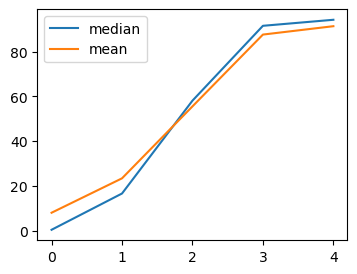

In [30]:
plt.figure(figsize=(4,3))
plt.plot(mediandata_endo[1],label="median")
plt.plot(meandata_endo[1],label="mean")
plt.legend()
plt.show()

# Now load the WT CS, and average them all 

In [31]:
CS_keep_mut=pd.read_csv("./2024_07_01_CSwmuttofit.csv",sep="\t",index_col=0)
inputcols=["GFP","LOW","MID","HIGH"]
individual_subdf_CS=[]
for group in ["WT","U1cons","BP_stg1","BP_weak3","Py-weak3"]:
    if group=="WT":
        namecat="WTCSrem"
    else:
        namecat="CSrem-"+group
    
    subdf=CS_keep_mut[CS_keep_mut["Subcat"]==group].copy()
    #in case each event is repeated multiple times, average
    subdf=subdf.groupby("event")[inputcols].mean()
    newcolnames=[namecat+":"+x for x in inputcols]
    subdf.columns=newcolnames
    display(subdf.head())
    individual_subdf_CS.append(subdf)

WTCSrem:GFP  WTCSrem:LOW  WTCSrem:MID  WTCSrem:HIGH
event                                                            
HsaEX1038166        7.305       12.620       48.130        90.400
HsaEX6024969       14.885       18.065       38.810        78.080
HsaEX6040016        7.320       10.220       22.665        55.015
HsaEX6077184       29.220       30.765       47.295        83.740
HsaEX6093676       41.290       45.240       46.065        60.030

CSrem-U1cons:GFP  CSrem-U1cons:LOW  CSrem-U1cons:MID  \
event                                                                
HsaEX1038166             90.94             94.03             96.65   
HsaEX6024969             15.74             19.15             42.50   
HsaEX6040016              6.98              7.77             19.35   
HsaEX6077184             45.26             43.83             62.69   
HsaEX6093676             40.81             45.68             46.67   

              CSrem-U1cons:HIGH  
event                            
HsaEX1038166              98.65  
HsaEX6024969              83.15  
HsaEX6040016              52.21  
HsaEX6077184              91.07  
HsaEX6093676              61.43

CSrem-BP_stg1:GFP  CSrem-BP_stg1:LOW  CSrem-BP_stg1:MID  \
event                                                                   
HsaEX1038166              28.93              42.62              71.67   
HsaEX6024969              94.39              96.40              97.68   
HsaEX6040016              11.33              13.92              32.47   
HsaEX6077184              94.23              93.79              96.00   
HsaEX6093676              93.02              93.28              93.12   

              CSrem-BP_stg1:HIGH  
event                             
HsaEX1038166               95.21  
HsaEX6024969               99.31  
HsaEX6040016               67.57  
HsaEX6077184               98.06  
HsaEX6093676               95.76

CSrem-BP_weak3:GFP  CSrem-BP_weak3:LOW  CSrem-BP_weak3:MID  \
event                                                                      
HsaEX1038166               11.61               22.07               57.27   
HsaEX6024969                4.55                3.68               16.86   
HsaEX6040016                0.75                0.78                1.00   
HsaEX6077184                1.67                1.34                1.83   
HsaEX6093676                0.92                1.05                1.08   

              CSrem-BP_weak3:HIGH  
event                              
HsaEX1038166                92.37  
HsaEX6024969                52.44  
HsaEX6040016                 4.00  
HsaEX6077184                 7.96  
HsaEX6093676                 1.40

CSrem-Py-weak3:GFP  CSrem-Py-weak3:LOW  CSrem-Py-weak3:MID  \
event                                                                      
HsaEX1038166                0.00                0.08                0.52   
HsaEX6024969                5.33                2.20                6.61   
HsaEX6040016                0.00                0.00                0.00   
HsaEX6077184                0.37                0.00                0.00   
HsaEX6093676                0.49                0.91                1.00   

              CSrem-Py-weak3:HIGH  
event                              
HsaEX1038166                 0.41  
HsaEX6024969                 7.36  
HsaEX6040016                 0.00  
HsaEX6077184                 0.79  
HsaEX6093676                 1.16

In [32]:
mediandata_CS=np.asarray([np.nanmedian(x.values,axis=0) for x in individual_subdf_CS]) #WT-minigene-LS, WT-minigene-HS, Py-weak1-LS,...
print(mediandata_CS.shape)



(5, 4)


In [33]:
groups_minigene=[x.columns[0].split(":")[0] for x in individual_subdf_minigene]
groups_minigene

['WTminigene-LS',
 'WTminigene-HS',
 'U1cons_a-LS',
 'U1cons_a-HS',
 'U1cons_b-LS',
 'U1cons_b-HS',
 'U6cons-LS',
 'U6cons-HS',
 'GTtoGC5ss-LS',
 'GTtoGC5ss-HS',
 'BP_stg1-LS',
 'BP_stg1-HS',
 'BP_weak3-LS',
 'BP_weak3-HS',
 'Py-stg3-LS',
 'Py-stg3-HS',
 'Py-weak3-LS',
 'Py-weak3-HS',
 'BP_stg1;Py-stg3-LS',
 'BP_stg1;Py-stg3-HS',
 'BP_weak3;Py-weak3-LS',
 'BP_weak3;Py-weak3-HS',
 'BP_stg1;Py-stg3;U1cons-LS',
 'BP_stg1;Py-stg3;U1cons-HS',
 '-ESS2-3-LS',
 '-ESS2-3-HS',
 '-ESE2-5-LS',
 '-ESE2-5-HS']

In [34]:
groups_endoWT=[x.columns[0].split(":")[0] for x in individual_subdf_endo]
groups_endoWT

['WTendo-LS', 'WTendo-HS']

In [35]:
groups_CS=[x.columns[0].split(":")[0] for x in individual_subdf_CS]
groups_CS

['WTCSrem',
 'CSrem-U1cons',
 'CSrem-BP_stg1',
 'CSrem-BP_weak3',
 'CSrem-Py-weak3']

# Fit only WT, U1 cons, BP_stg1, BP_weak3

In [19]:
groups_tofit=['WTendo-LS','WTendo-HS','WTminigene-LS','WTminigene-HS','U1cons_a-LS','U1cons_a-HS','U1cons_b-LS','U1cons_b-HS','BP_stg1-LS','BP_stg1-HS','BP_weak3-LS',
 'BP_weak3-HS']
allgroups=groups_endoWT+groups_minigene+groups_CS
allindividual=individual_subdf_endo+individual_subdf_minigene+individual_subdf_CS
mediandata=[x for x in mediandata_endo]+[x for x in mediandata_minigene]+[x for x in mediandata_CS]
allgroups_subset=[]
mediandata_subset=[]
allindividual_subset=[]
for i in range(len(allgroups)):
    group=allgroups[i]
    if group in groups_tofit:
        allgroups_subset.append(group)
        allindividual_subset.append(allindividual[i])
        mediandata_subset.append(mediandata[i])
allgroups_subset

['WTendo-LS',
 'WTendo-HS',
 'WTminigene-LS',
 'WTminigene-HS',
 'U1cons_a-LS',
 'U1cons_a-HS',
 'U1cons_b-LS',
 'U1cons_b-HS',
 'BP_stg1-LS',
 'BP_stg1-HS',
 'BP_weak3-LS',
 'BP_weak3-HS']

In [20]:
ratenames="alpha0,c1,c2,c3_,c4,c7,c8,ke,kes,kis,kisr_".split(",") #parameters of the function to calculate psi
inputnames_mini="GFP,CTR,LOW,HIGH".split(",") #minigene
inputnames_endo="GFP,CTR,LOW,MID,HIGH".split(",") #endogenous

sysfunc=auxfuncs_fitting.psi_linear_system1

In [21]:
#For each mutation, put the index of the parameter that is affected. Considering all the rates that go into solve_linear_system



groups=allgroups_subset
individual_subdfs=allindividual_subset
mediandata=mediandata_subset

ngroups=len(groups)

minv=-4
maxv=4

parranges={'c7':[1,maxv],'c8':[minv,1],"LOW":[0,3],"MID":[0,3],"HIGH":[0,3]} #log10 scale #minigene does not have MID, careful because in the paper the nomenclature is different. CTR here is low in the paper, and LOW here is mid in the paper, HIGH here is HIGH in the paper 

fixedpars=OrderedDict({"GFP":0,"CTR":1})  #natural scale. 

bestpars_perratesdif=dict()
ratesdif=["c2"]
ratesdif_str=";".join(ratesdif)
print("assuming groups differ in %s"%ratesdif_str)


pars_per_group=[] #can be different
for group in groups:
    rates_=[]
    for rate in ratesdif:
        rates_.append("%s:%s"%(rate,group))
    pars_per_group.append(rates_)
print(pars_per_group)



pars_per_group_refine=[]
for group in groups:
    rates_=[]
    
    rates_.append("%s:%s"%("c2",group))
    #else:
    #    for rate in ["c2","kis"]:
    #        rates_.append("%s:%s"%(rate,group))
    #rates_.append("%s:%s"%("kis",group))
    #if "Py-stg3;U1cons" in group:
    #    pars_per_group_refine[group]=["c2","kis"]
    #else:
    pars_per_group_refine.append(rates_)
print(pars_per_group_refine)



getparskwargs=auxfuncs_fitting.return_parsdict(groups,inputnames=inputnames_endo,pars_per_group=pars_per_group, pars_per_group_refine=pars_per_group_refine,ratenames=ratenames, minv=minv, maxv=maxv, parranges=parranges,fixedpars=fixedpars)
parsetnames=getparskwargs["idxsdict_global"]["parsetnames"]
print(parsetnames)
print("bounds",getparskwargs["bounds"])
getparskwargs["rates_condition_refine"]=pars_per_group_refine

NPARS=len(parsetnames) 
print(NPARS, "parameters")
errorargs={"data":mediandata,"additional_data":None,
           "npars":len(getparskwargs["inputnames"])+len(getparskwargs["ratenames"]),
      "sysfunc":sysfunc,
      "errorfunc":auxfuncs_fitting.abserror,
      "individual_error":False,
      "plot":False,
      "plotkwargs":None}

ncol=6
nrow=int(np.ceil(len(individual_subdfs)/ncol))
errorargs_withplotting=errorargs.copy()
errorargs_withplotting["plotkwargs"]={"nrow":nrow,"ncol":ncol,"titles":[x.columns[0].split(":")[0] for x in individual_subdfs]}
errorargs_withplotting["plot"]=True
errorargs_withplotting["additional_data"]=[x.values for x in individual_subdfs]

fitnessfunc=partial(auxfuncs_fitting.error_and_plot,getparskwargs=getparskwargs,**errorargs)


POPULATION_SIZE = 400
MAX_GENERATIONS = 300

P_CROSSOVER = 0.25  # probability for crossover
P_MUTATION = 0.6   # probability for mutating an individ
MUTSIGMA=0.5 #sigma
INDPB=0.25

pars_genetic={"POPULATION_SIZE":POPULATION_SIZE, "MAX_GENERATIONS": MAX_GENERATIONS, 
              "P_CROSSOVER": P_CROSSOVER,"P_MUTATION": P_MUTATION, "MUTSIGMA": MUTSIGMA, "INDPB": INDPB,
              "HALL_OF_FAME_SIZE": 3,
             "fitnessfunc": fitnessfunc,
             "seeds":np.arange(1,10), 
              "plot_fitness_evo":True, 
              "plotintermediates":True, 
              "plotbest":True, 
              "errorargs_withplotting":errorargs_withplotting, 
              "getparskwargs":getparskwargs}

assuming groups differ in c2
[['c2:WTendo-LS'], ['c2:WTendo-HS'], ['c2:WTminigene-LS'], ['c2:WTminigene-HS'], ['c2:U1cons_a-LS'], ['c2:U1cons_a-HS'], ['c2:U1cons_b-LS'], ['c2:U1cons_b-HS'], ['c2:BP_stg1-LS'], ['c2:BP_stg1-HS'], ['c2:BP_weak3-LS'], ['c2:BP_weak3-HS']]
[['c2:WTendo-LS'], ['c2:WTendo-HS'], ['c2:WTminigene-LS'], ['c2:WTminigene-HS'], ['c2:U1cons_a-LS'], ['c2:U1cons_a-HS'], ['c2:U1cons_b-LS'], ['c2:U1cons_b-HS'], ['c2:BP_stg1-LS'], ['c2:BP_stg1-HS'], ['c2:BP_weak3-LS'], ['c2:BP_weak3-HS']]
parsetnames_fixed ['GFP', 'CTR']
parsetnames ['LOW', 'MID', 'HIGH', 'alpha0', 'c1', 'c2:WTendo-LS', 'c2:WTendo-HS', 'c2:WTminigene-LS', 'c2:WTminigene-HS', 'c2:U1cons_a-LS', 'c2:U1cons_a-HS', 'c2:U1cons_b-LS', 'c2:U1cons_b-HS', 'c2:BP_stg1-LS', 'c2:BP_stg1-HS', 'c2:BP_weak3-LS', 'c2:BP_weak3-HS', 'c3_', 'c4', 'c7', 'c8', 'ke', 'kes', 'kis', 'kisr_']
parsetnames_fixed ['GFP', 'CTR']
parsetnames ['LOW', 'MID', 'HIGH', 'alpha0', 'c1', 'c2:WTendo-LS', 'c2:WTendo-HS', 'c2:WTminigene-LS', 'c2:W

unique_bounds_str ['-4;1' '-4;4' '0;3' '1;4']
seed 1


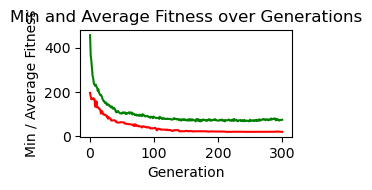

after refinement
fitness 16.99346176077996
1.0438368166977046,2.1392105433278683,2.577799976235123,-3.0443710070850334,-0.9243151218856255,2.223307554387115,-1.536242901737313,1.9672389435674635,-1.0381197885259197,-0.13181080664561556,-1.2032145901623064,-1.2900908735186265,-2.4078756167605726,1.202298139803664,-2.862069626050549,4.0,2.111974203618672,-2.583731593999112,-0.6550951519390863,1.0037954498835122,-1.4754957841909293,-1.5166962419301528,-3.0700395824074027,-3.4968163106042933,2.666954994329855


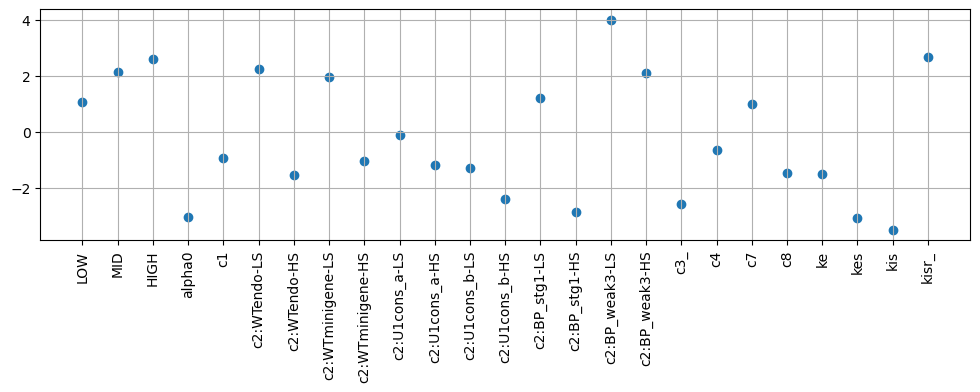

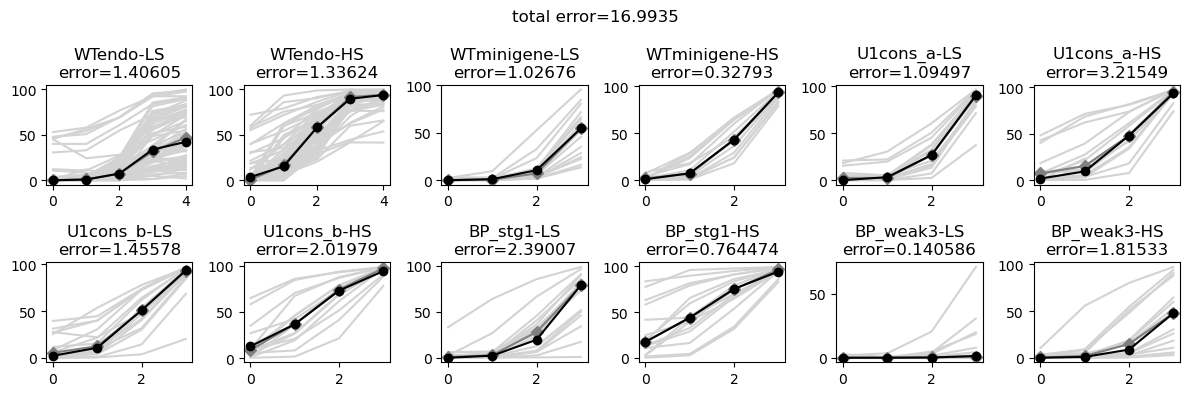

after refinement
fitness 17.16707394384865
1.0438368166977046,2.1392105433278683,2.7335850457793507,-3.0443710070850334,-0.9243151218856255,2.223307554926003,-1.5362429050075834,2.0125979528569964,-1.0381197885513138,0.42656755345531994,-1.2032145958653118,-1.2900908736436232,-2.4078756164220887,1.3216340320922244,-2.862069627477295,4.0,2.1523406779438257,-2.583731593999112,-0.6550951519390863,1.0037954498835122,-1.4754957841909293,-1.5166962419301528,-3.0700395824074027,-3.4968163106042933,2.666954994329855


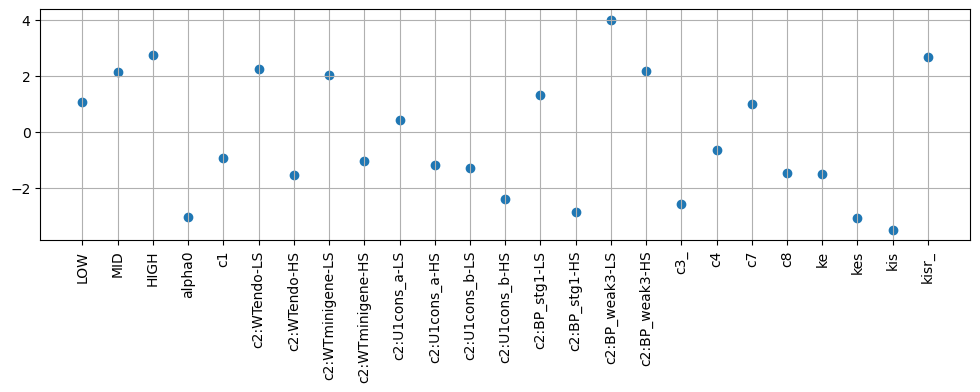

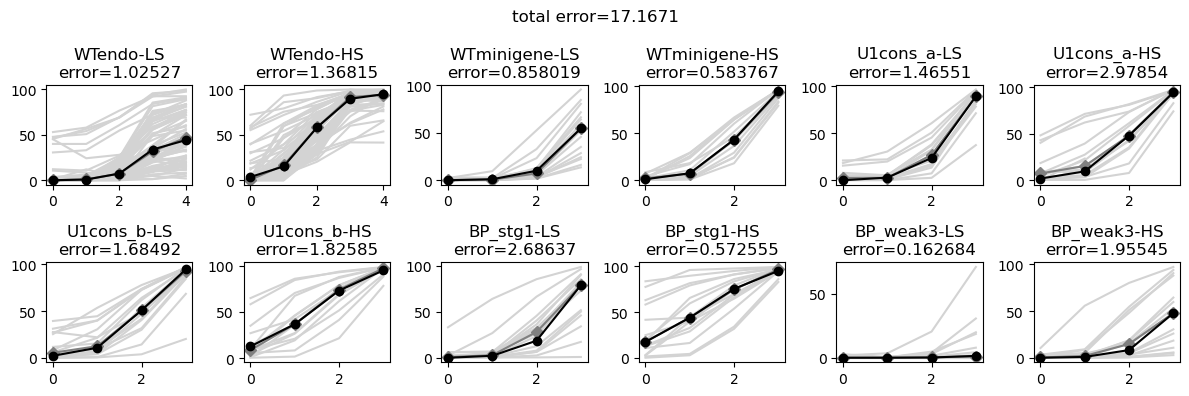

after refinement
fitness 17.14959081950838
1.0438368166977046,2.1392105433278683,2.7335850457793507,-3.0443710070850334,-0.9243151218856255,2.223147417023545,-1.5318163369293787,2.011595771837163,-1.0337513206327031,0.427371501174659,-1.1990198551741234,-1.2859107539530532,-2.4035791593975495,1.320986150490672,-2.854997490715445,4.0,2.1513135621370347,-2.583731593999112,-0.6550951519390863,1.0,-1.4754957841909293,-1.519351097253669,-3.0700395824074027,-3.4968163106042933,2.666954994329855


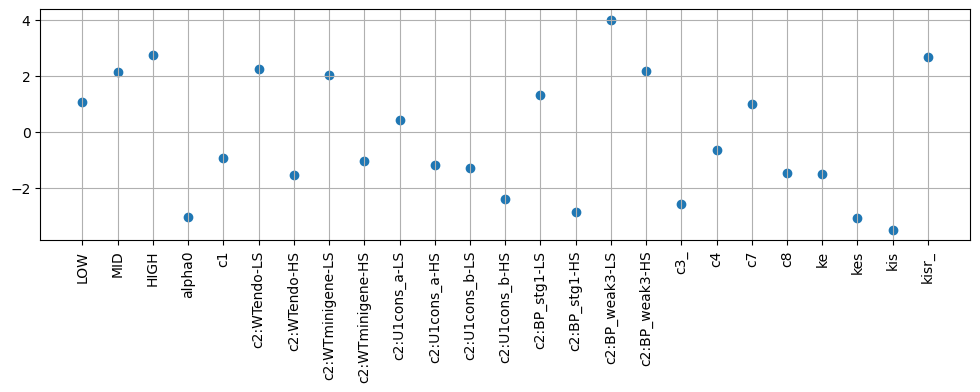

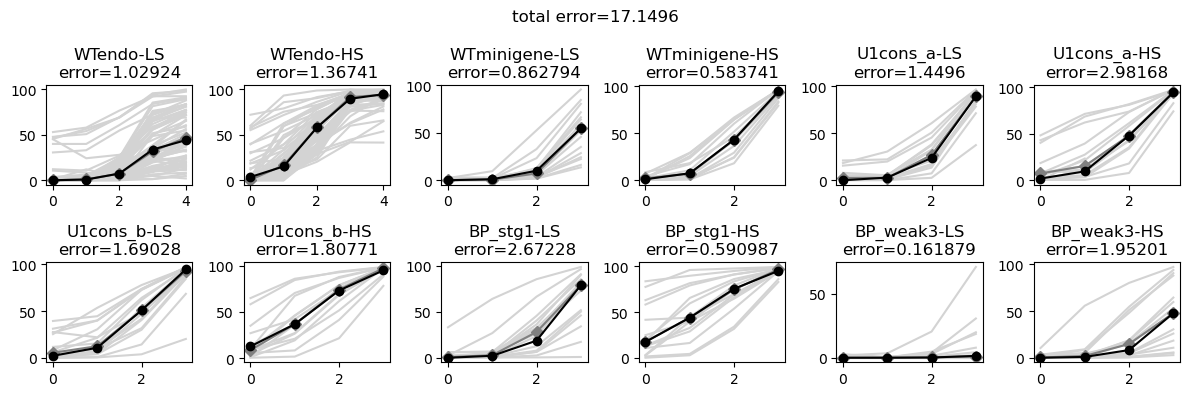

seed 2


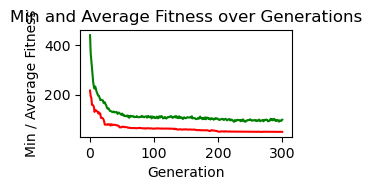

after refinement
fitness 40.693699132777525
1.0683204614478055,2.2152413063104666,2.4460514964976694,4.0,-2.5630998053996534,2.939032573336774,-0.02591845882900147,2.724766072639695,0.92142257601186,1.4395388699592817,0.728121767340653,0.600524478088074,-4.0,1.4061455653782349,-4.0,4.0,2.9166378961275954,-0.2791878028384102,3.380405035969418,1.0,0.24026203313922576,-3.898194996793635,-0.5115270815457014,-1.6579633857996763,4.0


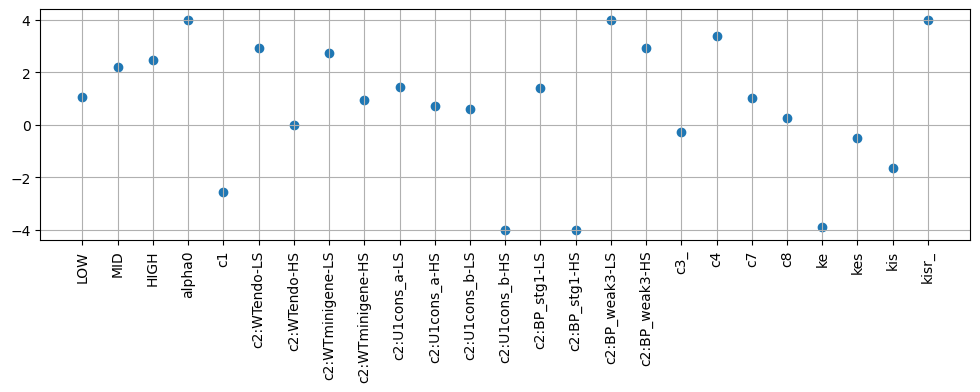

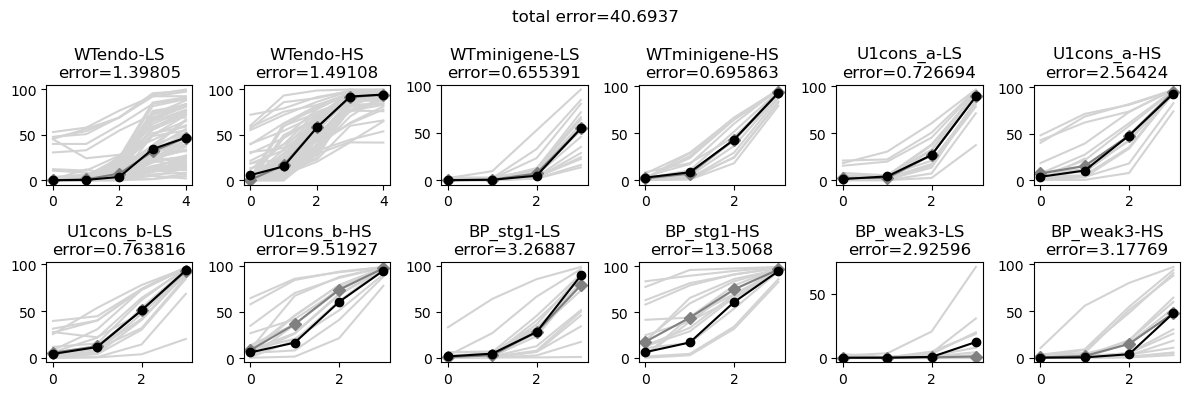

after refinement
fitness 40.784869548634774
1.0683204614478055,2.2152413063104666,2.4460514964976694,4.0,-2.5178869392094945,3.009641773450146,0.05851012920331491,2.7958112706878704,0.9737010406338711,1.4916154939883017,0.7823985975336414,0.6569175050043968,-4.0,1.458031505162298,-4.0,4.0,2.987460485350143,-0.2791878028384102,3.380405035969418,1.0,0.24026203313922576,-3.898194996793635,-0.5115270815457014,-1.6579633857996763,4.0


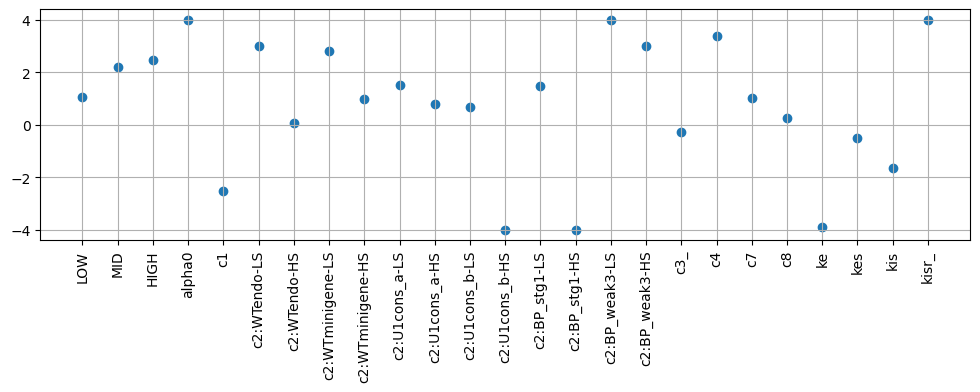

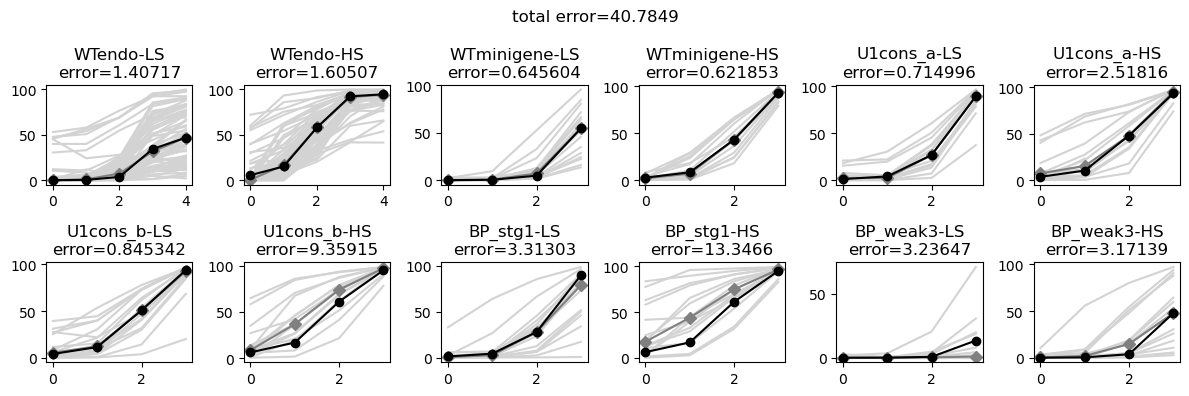

after refinement
fitness 41.89014598237462
1.0683204614478055,2.2152413063104666,2.451054717424344,3.8313360628129844,-2.5178869392094945,2.9553205166342704,-0.43846581363983733,2.7392999712248995,0.8958499341717291,1.4364657254951554,0.683824583870679,0.5376793503326959,-4.0,1.4022827456629503,-4.0,4.0,2.9328016155703294,-0.3190400184284452,3.380405035969418,1.0,0.24026203313922576,-3.898194996793635,-0.5115270815457014,-1.6579633857996763,4.0


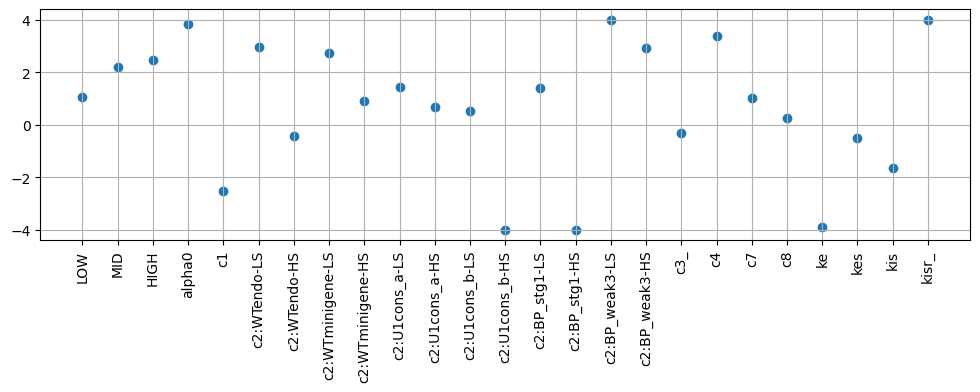

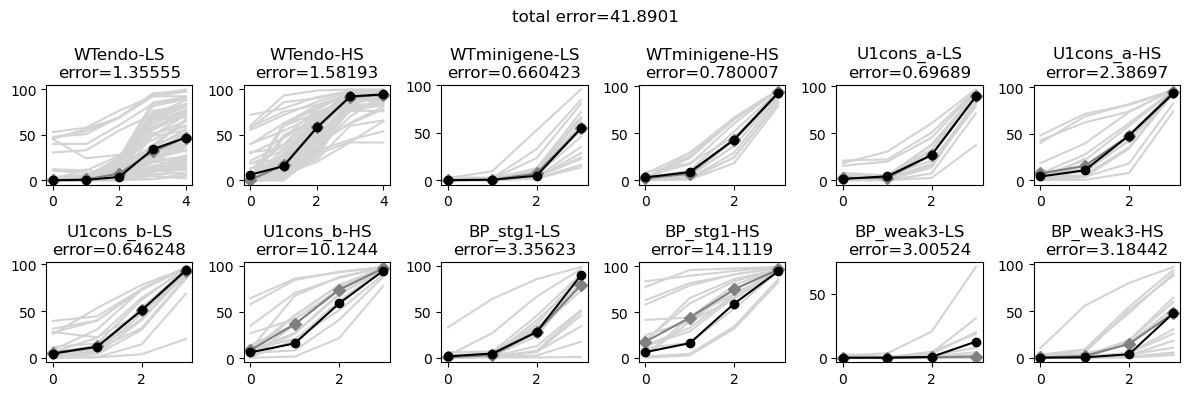

seed 3


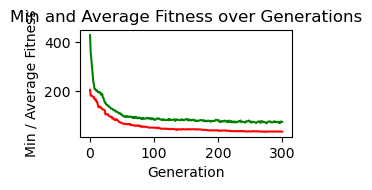

after refinement
fitness 24.831782669259773
0.8035457807202417,2.264177186732912,2.488549636191804,2.118970577363509,1.8920431010447363,1.6885585355240502,-0.6156512018959821,1.4941988833122757,-0.19936358373249685,0.19770276585803095,-0.3224775126959938,-0.3933111281429833,-2.6944120857843195,0.170329130229713,-4.0,4.0,1.6673775535020223,-2.3115631184397274,-1.7453179097822786,1.0,0.2752371183398716,0.5810734871552925,-2.0395185092991452,-3.0237642508735814,3.8916891160338265


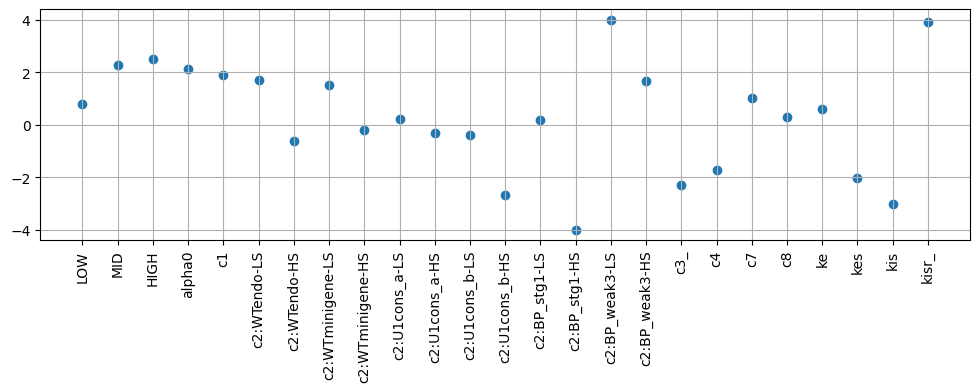

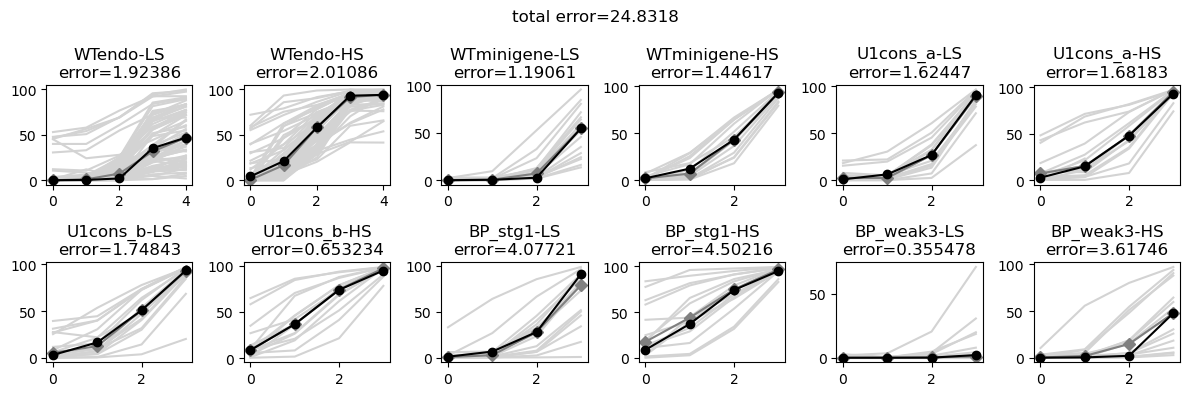

after refinement
fitness 25.305240088208844
0.8035457807202417,2.264177186732912,2.488549636191804,1.5768473951274893,1.8541392131428516,1.662565068444271,-0.6635765247745322,1.4630839283362045,-0.24212320214315589,0.15692927658064784,-0.3662924065129007,-0.43788109840020334,-4.0,0.12946463352915685,-4.0,4.0,1.640717543461779,-2.3115631184397274,-1.296285176571718,1.1031130900528496,0.2752371183398716,0.5810734871552925,-2.0395185092991452,-3.0237642508735814,3.8916891160338265


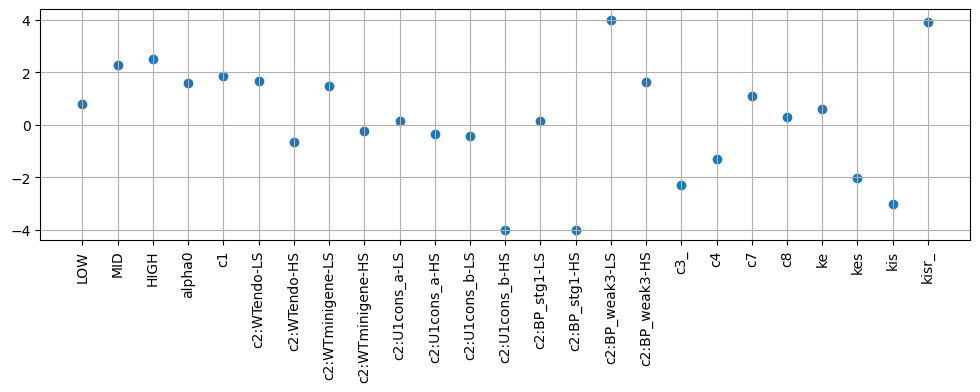

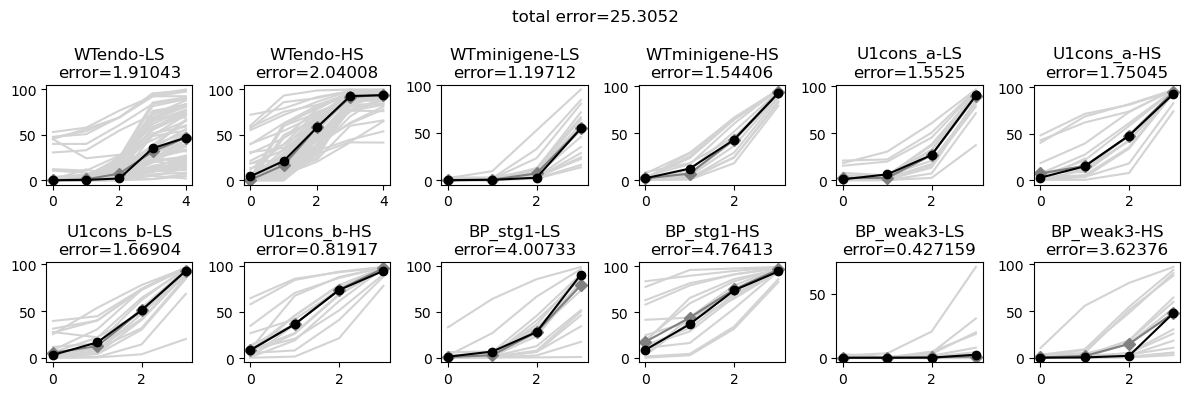

after refinement
fitness 25.525820041420264
0.8035457807202417,2.2527763891415904,2.488549636191804,1.7034690793134373,1.8541392131428516,1.6911725208766524,-0.6545562660703698,1.484736918706046,-0.23191604814514027,0.16774734153037052,-0.3563416016119223,-0.428106176225592,-2.6867415945786584,0.1402433603378618,-4.0,4.0,1.6683901460608366,-2.3115631184397274,-1.7453179097822786,1.0,-0.45860352580356817,0.5699027932841118,-2.0395185092991452,-2.987973541825235,3.3410666765717054


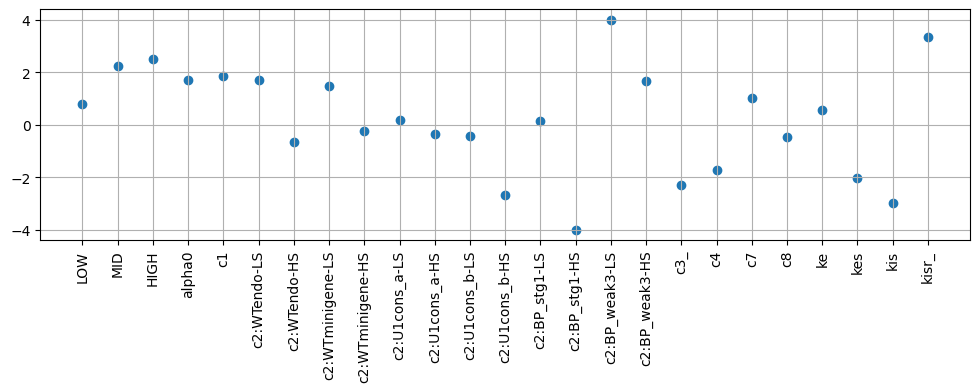

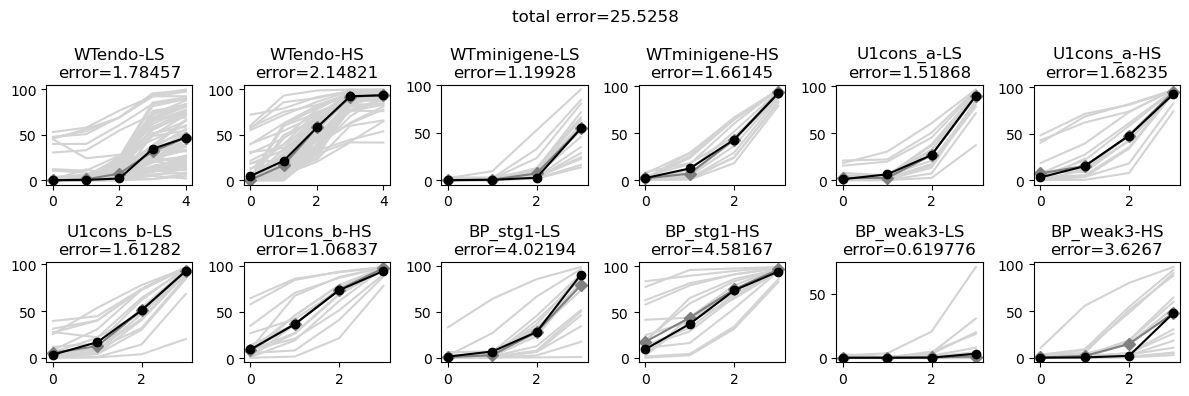

seed 4


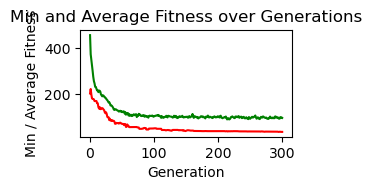

after refinement
fitness 32.34176171225096
0.6375631917605559,1.6687164483971442,3.0,-3.8112488368694257,-2.7949670035881162,3.692351138619142,-1.3419686755759757,3.44796091147486,-0.7770423806019913,1.77001799874566,-0.970847249877375,-1.0693775776402812,-2.435889484577053,2.6972381189216,-3.9810898617007244,4.0,3.5923367441973424,-1.374469075600044,0.033841025102285774,3.181739520623094,-2.6699064222059357,-1.7571843309349002,-2.7634360010173284,-2.8584659214235355,1.6786335766303566


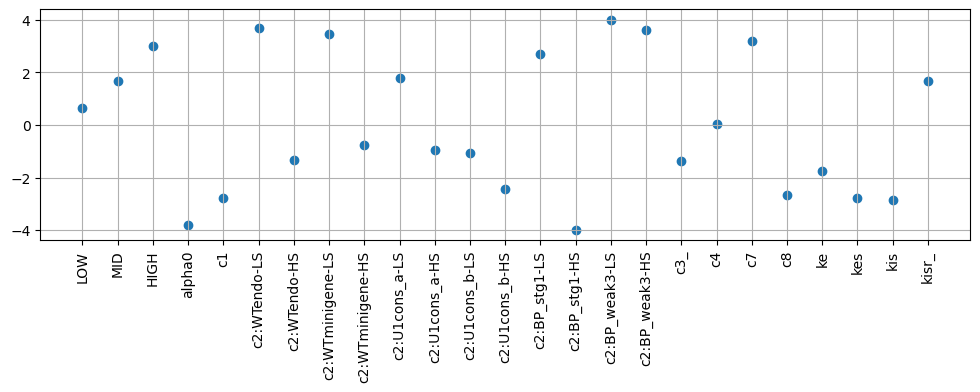

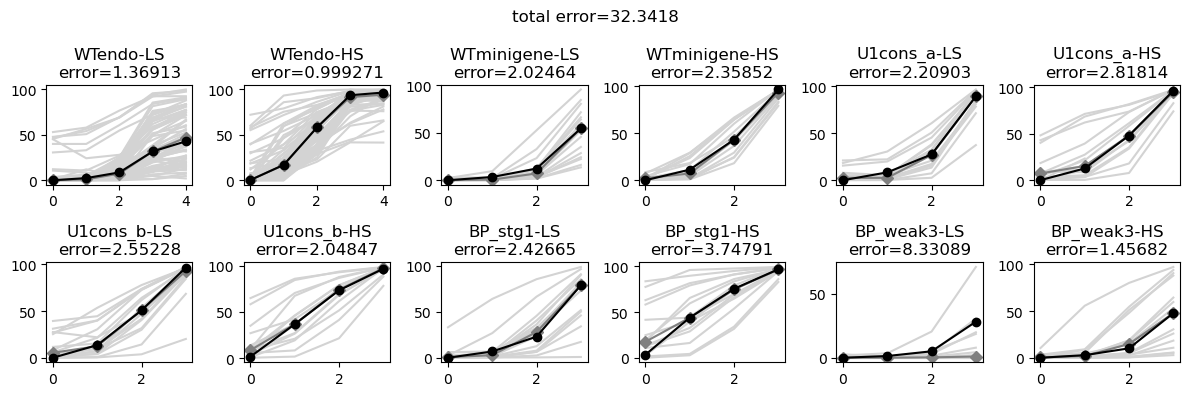

after refinement
fitness 32.34176169757373
0.6375631917605559,1.6687164483971442,3.0,-3.666343720463427,-2.7949670035881162,3.6923511376320035,-1.3419686755761004,3.447960911579355,-0.7770423802376817,1.7700179986067814,-0.9708472496928899,-1.0693775772443856,-2.435889485694529,2.6972381188966152,-3.9810898617256227,4.0,3.5923367452229273,-1.374469075600044,0.033841025102285774,3.181739520623094,-2.6699064222059357,-1.7571843309349002,-2.7634360010173284,-2.8584659214235355,1.6786335766303566


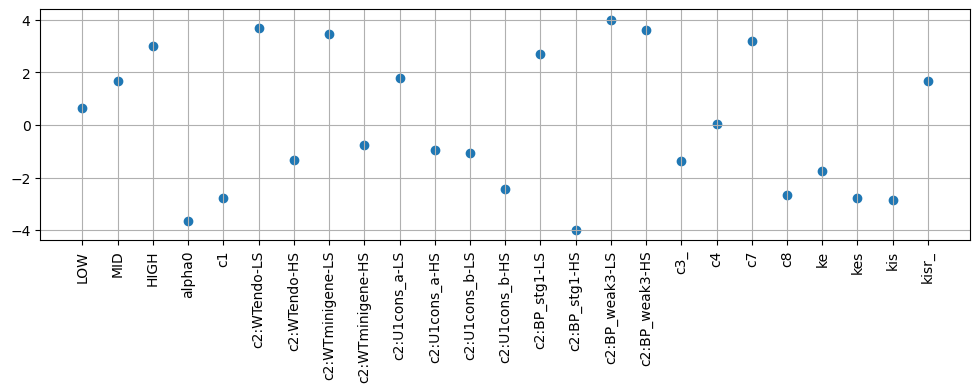

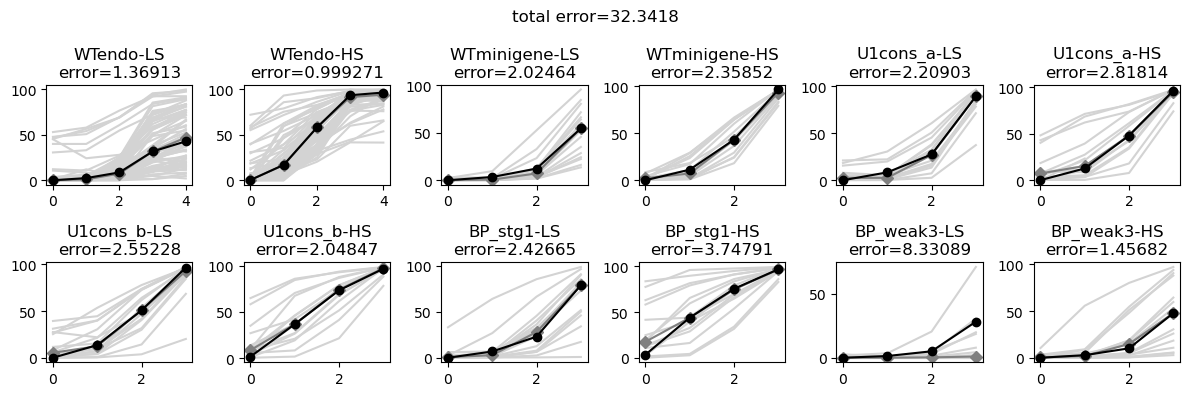

after refinement
fitness 32.50595469174055
0.6375631917605559,1.6687164483971442,3.0,-3.7751193634437525,-2.978974223346687,3.6737106506775605,-1.35507761726484,3.4280056141847006,-0.7919627888802846,1.73602875622274,-0.9843233854669863,-1.0824720319009438,-2.473857990085801,2.6657191318309597,-4.0,4.0,3.5732615984586147,-1.374469075600044,0.033841025102285774,3.348973837377582,-2.6699064222059357,-1.7571843309349002,-2.7634360010173284,-2.8584659214235355,1.6786335766303566


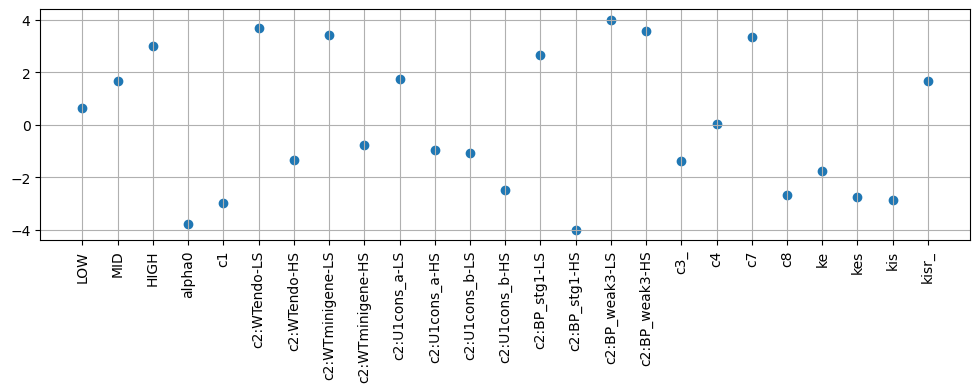

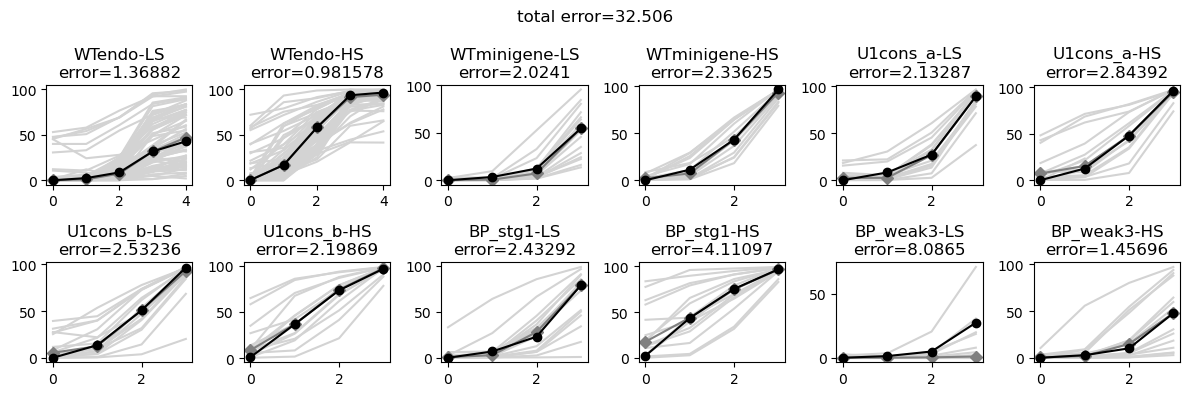

seed 5


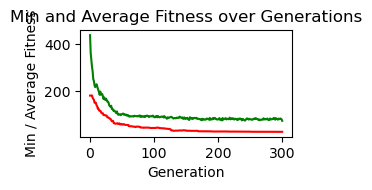

after refinement
fitness 25.180400845481596
0.7899353459842279,2.0663628144709625,2.3446671911318955,-3.712189189951822,3.366846673512531,2.1119128114471986,0.1441035490025514,1.9640253690248202,0.4922181086768638,0.8829531467456612,0.3711568924205562,0.3016355543566952,-4.0,0.8560688303136456,-4.0,3.9999999999999996,2.096381062260103,-1.0709661404351567,1.925390898040778,1.8957218375374723,-0.7046189667740191,1.94203643539827,-1.456889142385986,-2.611740259075934,4.0


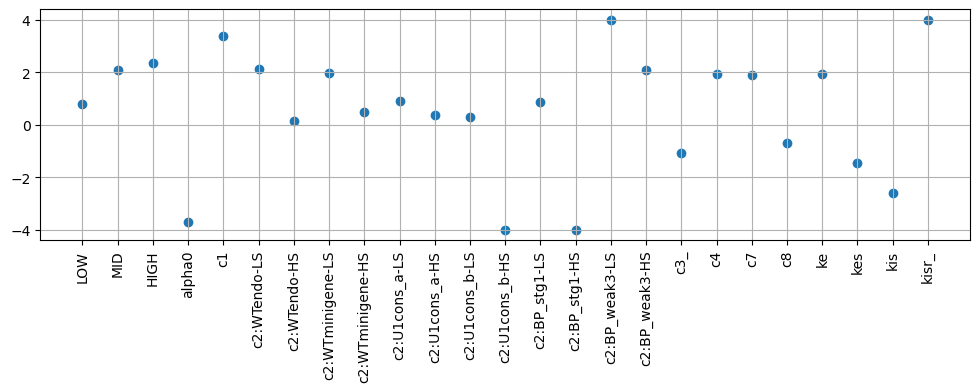

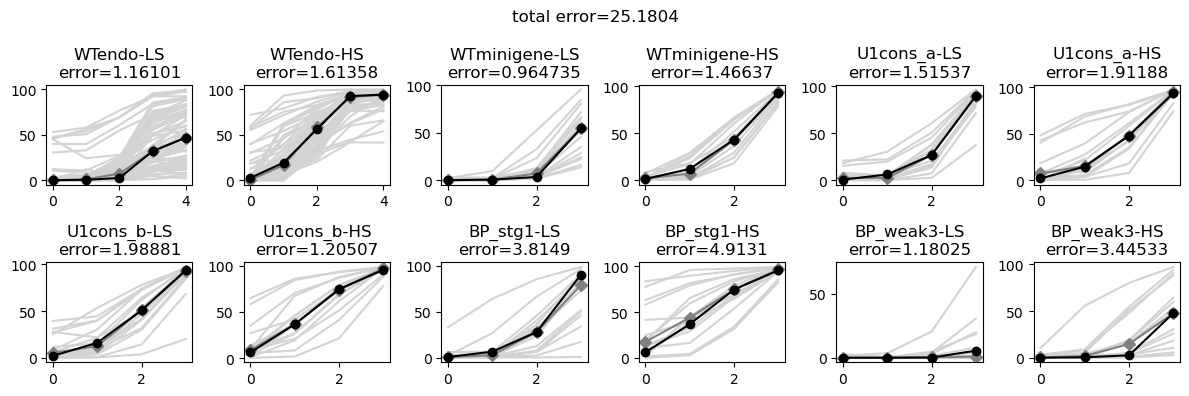

after refinement
fitness 25.199968668314554
0.7899353459842279,2.0663628144709625,2.3446671911318955,-3.411588078755684,3.366846673512531,2.11220487069975,0.1440152581274799,1.964286044785429,0.49222588257179417,0.8829638575547634,0.37116418969611215,0.3016426373001479,-4.0,0.856079241917432,-4.0,4.0,2.0966692493054686,-1.0709661404351567,1.925390898040778,2.455266984892425,-0.7046189667740191,1.94203643539827,-1.456889142385986,-2.611740259075934,4.0


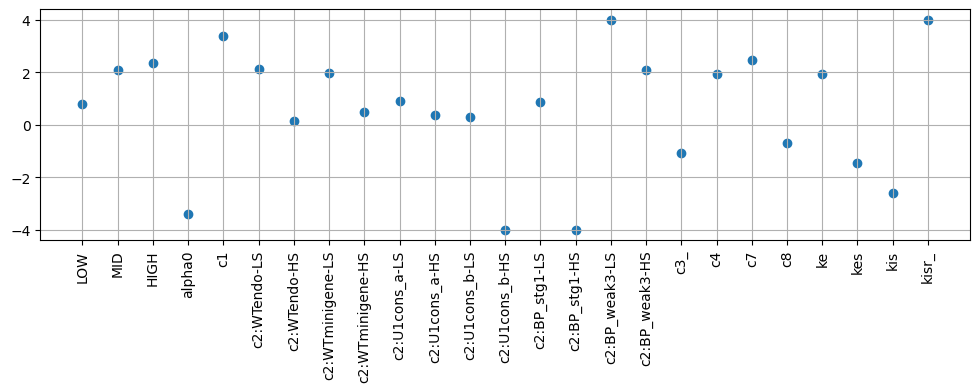

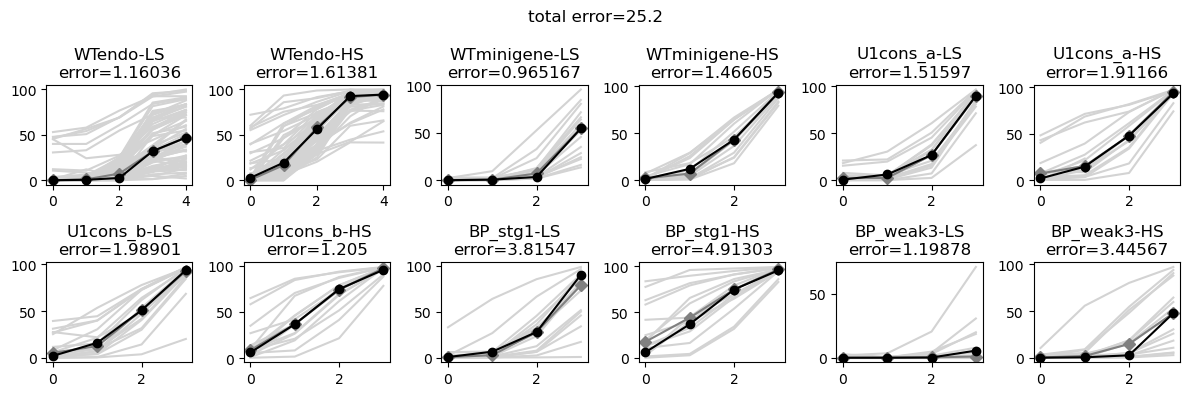

after refinement
fitness 25.687077903625397
0.7899353459842279,2.0663628144709625,2.3731764226031666,-3.756198732242183,3.366846673512531,2.142882359319596,0.1363237722712347,1.994576445268606,0.4922266731259697,0.8829649460777375,0.3711649326728717,0.301643357171216,-4.0,0.8560802992136299,-4.0,4.0,2.127296798904679,-1.0709661404351567,1.925390898040778,2.5900012930402845,-0.7046189667740191,1.94203643539827,-1.456889142385986,-2.611740259075934,4.0


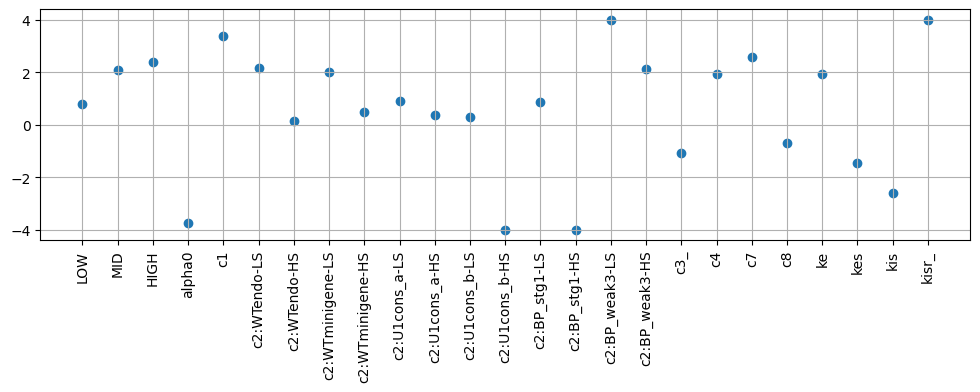

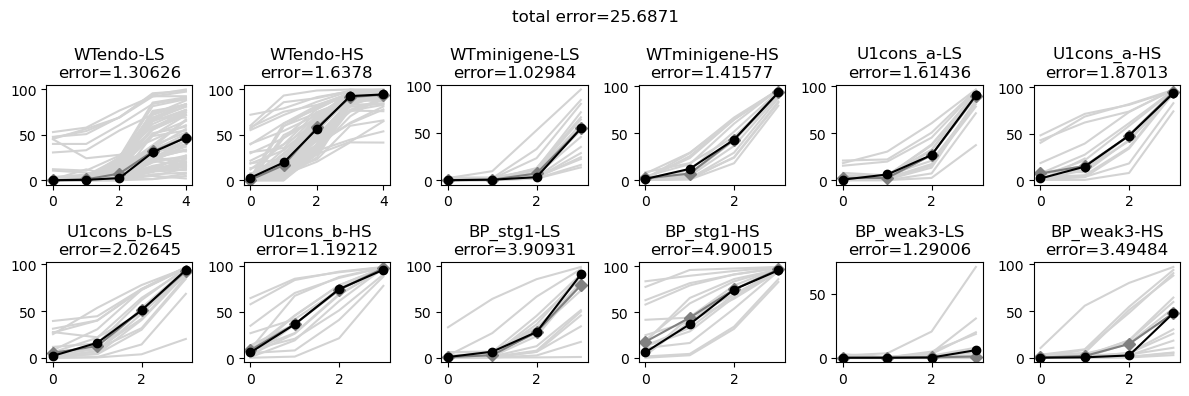

seed 6


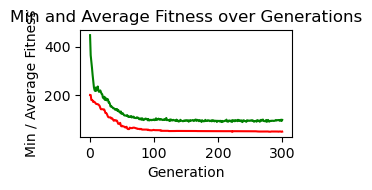

after refinement
fitness 45.8807996313029
1.2896061392883318,2.205909758005967,2.677928118285713,-1.238453042201642,-0.6249194383505744,3.4751959631946354,-4.0,3.3232876275047674,1.2386061670466448,2.1342583242762188,0.93990166722816,0.7313158002464325,-4.0,2.6953778068330596,-4.0,4.0,3.4594996205889847,-0.6946246626533251,1.760701241769928,3.4430870394190296,0.0570201398243522,0.459026241683617,-1.1518017981311441,1.0870911214856218,0.2924202218003642


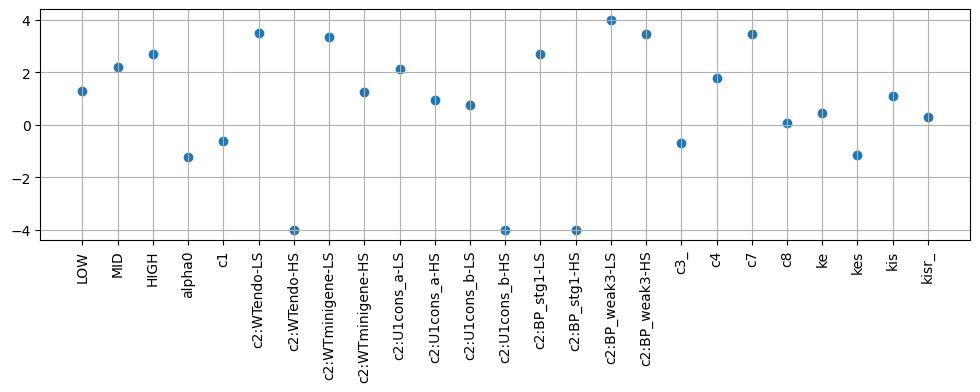

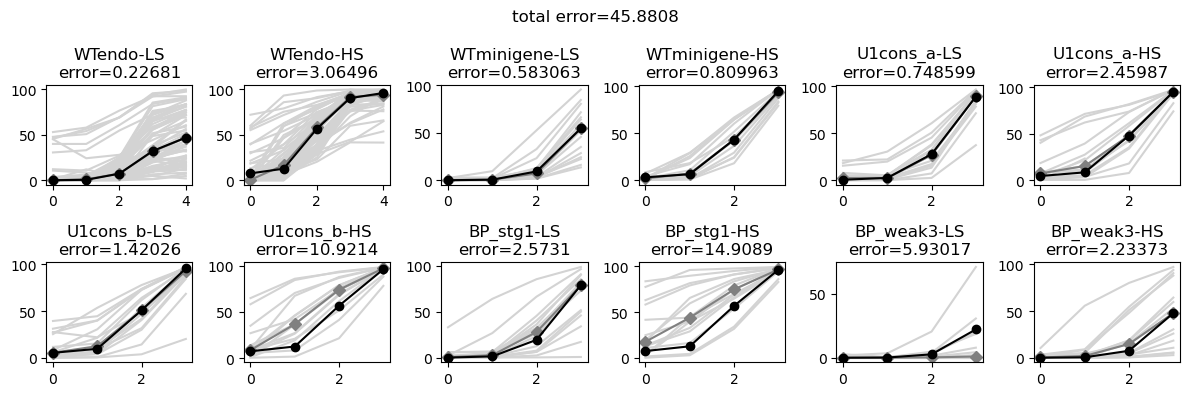

after refinement
fitness 45.73547213913079
1.2896061392883318,2.205909758005967,2.677928118285713,-1.0380825285816808,-0.6249194383505744,3.476297250644884,-4.0,3.3248496438232578,1.244702916920731,2.1349326632302903,0.9500470251273514,0.746487514023488,-4.0,2.7017131809424244,-4.0,4.0,3.460641453789096,-0.6946246626533251,1.760701241769928,3.4430870394190296,0.0570201398243522,0.459026241683617,-1.9424975180602062,1.0870911214856218,0.2924202218003642


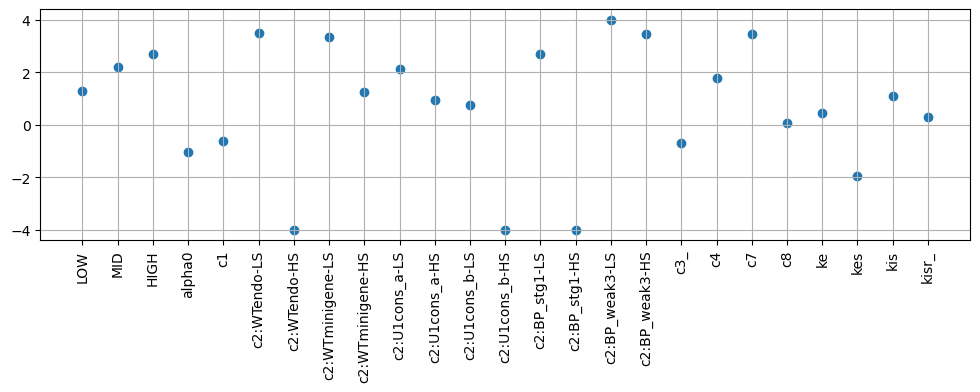

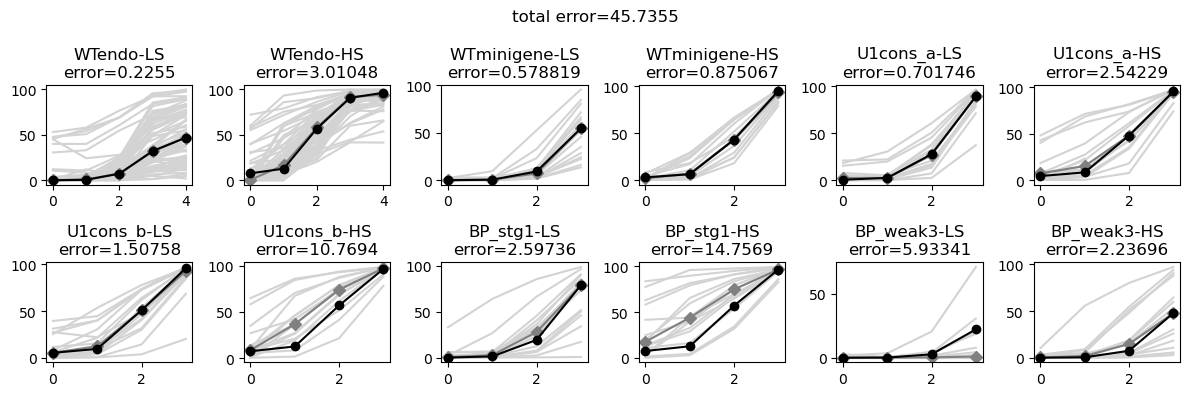

after refinement
fitness 45.809938446611135
1.2896061392883318,2.205909758005967,2.677928118285713,-1.238453042201642,-0.6249194383505744,3.4757359100768603,-4.0,3.324053674403902,1.241601480869599,2.1345887525003633,0.9448984094787922,0.7388104110090431,-4.0,2.6984929037897887,-4.0,4.0,3.460059462091852,-0.6946246626533251,1.760701241769928,3.4430870394190296,0.0570201398243522,0.459026241683617,-1.3814148394264738,1.0870911214856218,0.2924202218003642


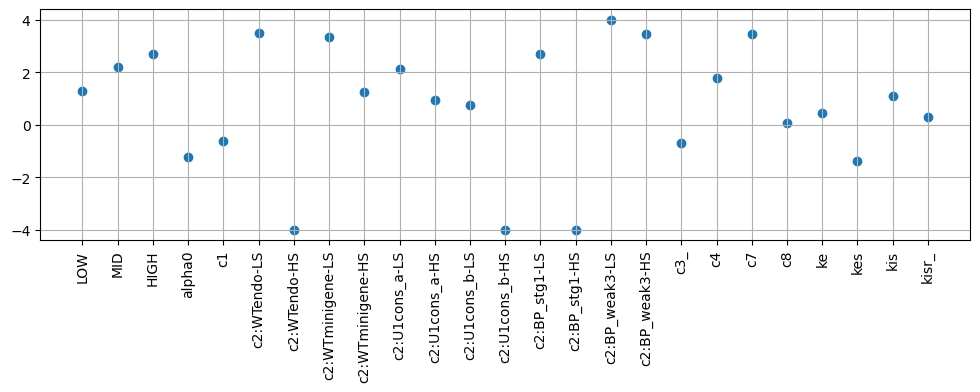

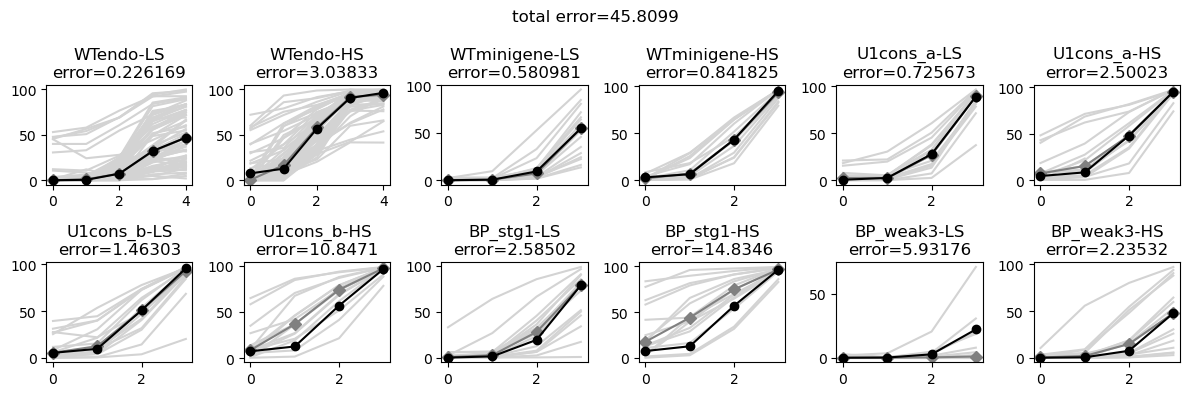

seed 7


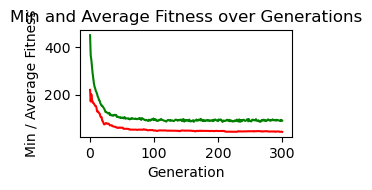

after refinement
fitness 37.525125821560806
1.866694399078253,2.8222663610376086,3.0,3.6467844811346555,1.150472046971228,1.499486089289064,-1.039712872878031,1.344489254757114,-0.5894637540291375,-0.18048262297742299,-0.7192783682120802,-0.7949906212851436,-4.0,-0.2083621011458724,-4.0,4.0,1.4831727887145836,-0.5311028719435437,1.7346985494920757,3.0210559516084357,-0.16718347918734247,1.021982410187534,-2.3482650163129373,-2.159426525723004,1.4369212357906591


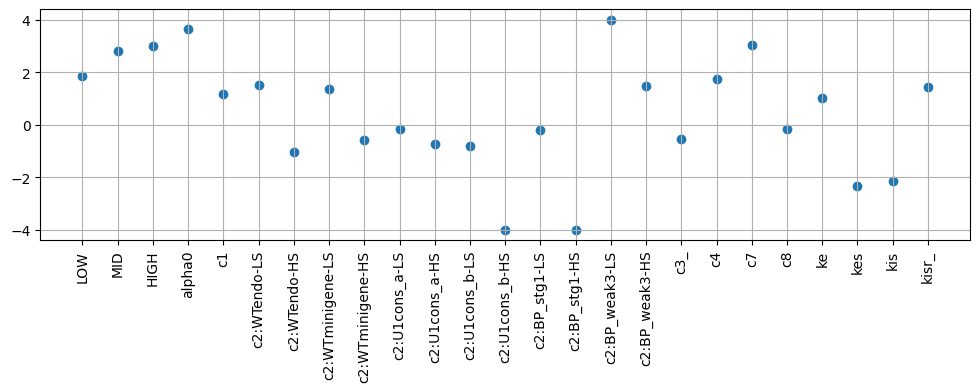

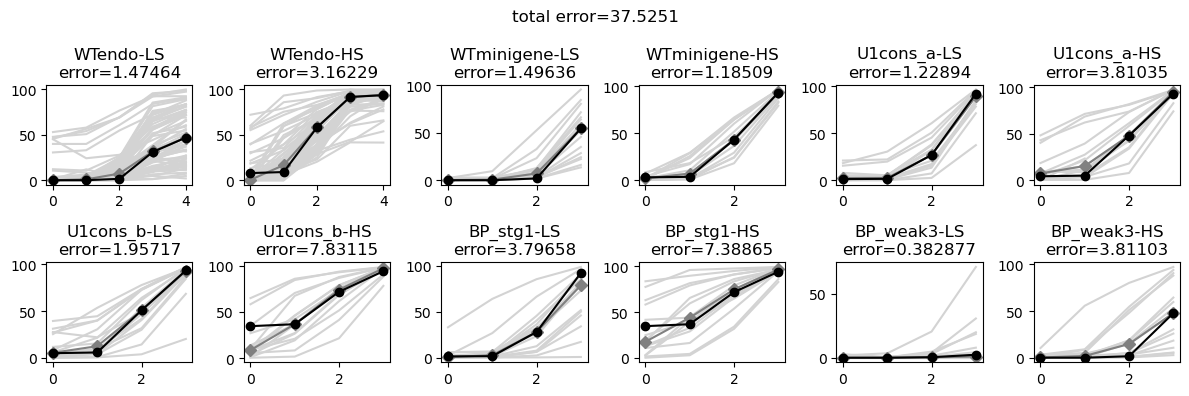

after refinement
fitness 40.36386774440471
1.866694399078253,2.6887833962924885,3.0,4.0,1.150472046971228,1.5456012290131453,-1.0206527374105407,1.3888286264447383,-0.5735006655061989,-0.16546008369867785,-0.7027309297341571,-0.7780075141397222,-2.9749725032038046,-0.1933067504258166,-4.0,4.0,1.5290548345522998,-0.5311028719435437,1.77469680745961,3.0210559516084357,-0.7320195851068456,1.021982410187534,-2.340535847468498,-2.109304231971145,1.4369212357906591


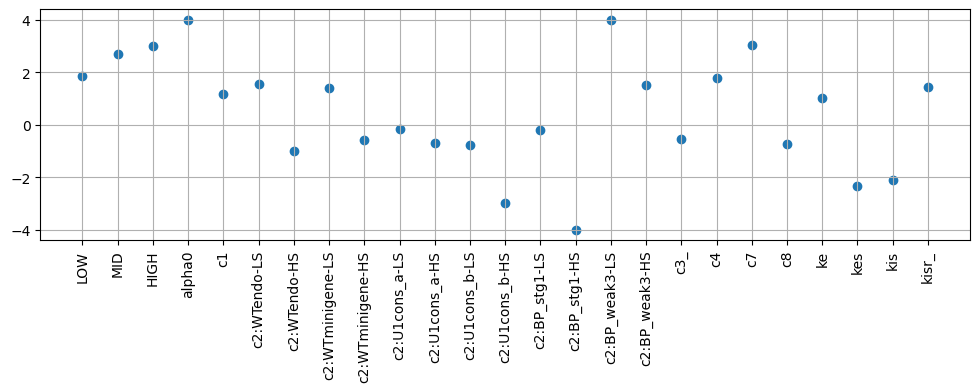

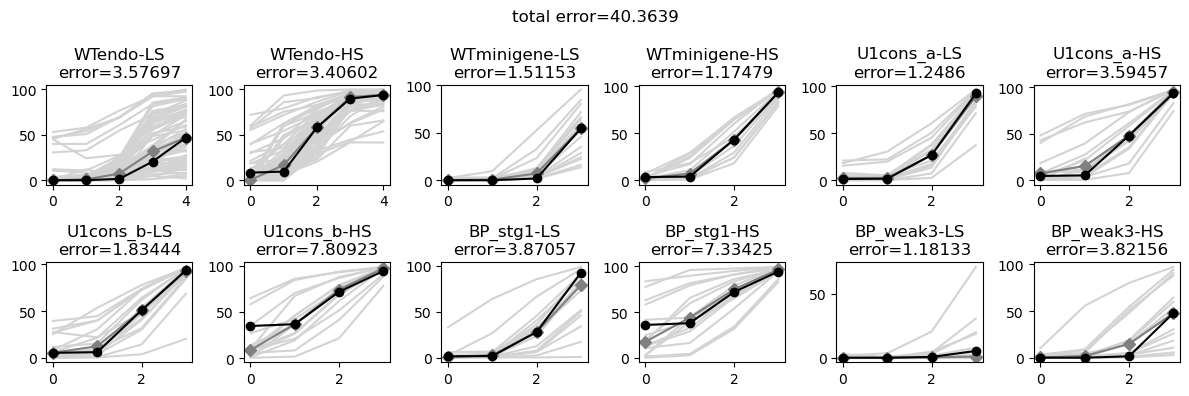

after refinement
fitness 38.238315341919325
1.866694399078253,2.8222663610376086,3.0,4.0,1.150472046971228,1.496593076207444,-1.0706950535116069,1.3405391284549335,-0.6002538728117061,-0.18470960374112982,-0.7338617006180562,-0.8123913990971823,-4.0,-0.2128652201994834,-4.0,4.0,1.4801856441382308,-0.5311028719435437,1.7346985494920757,3.0210559516084357,-0.16718347918734247,1.021982410187534,-2.259079461489747,-2.159426525723004,1.4369212357906591


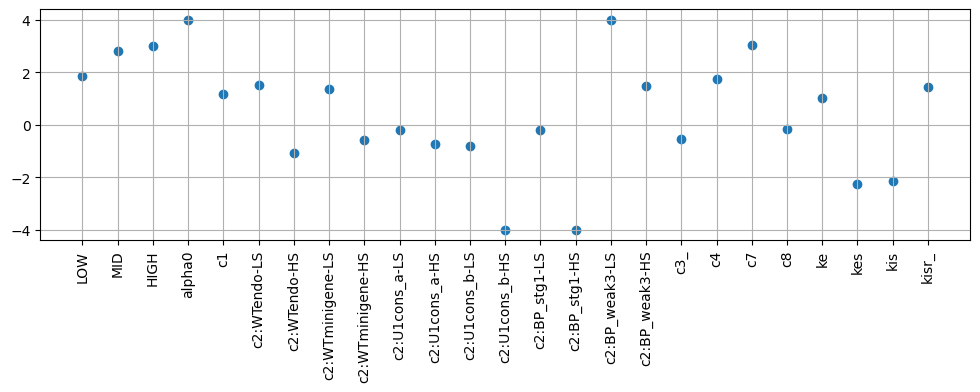

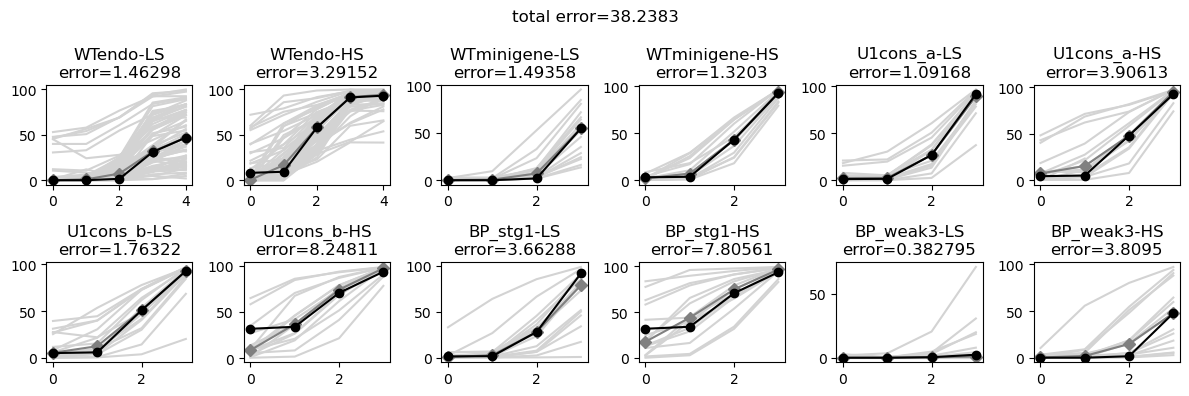

seed 8


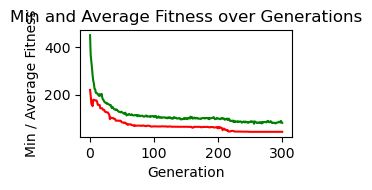

after refinement
fitness 39.72151720282884
0.8214522745251931,1.7591028820092056,2.0783679038274805,3.156112426501769,1.3080846102699664,0.10157952990317802,2.9189941952170364,0.8676029637669226,2.550667111964277,2.143706677504388,2.66603308725742,2.7300884220373756,4.0,2.173679687211065,4.0,-4.0,-0.37954650170983484,-3.482661516308166,-1.0527852278120102,4.0,-2.6401705228791337,-3.320729162636546,-1.3825948236553782,-3.503926446003636,3.8741145142538076


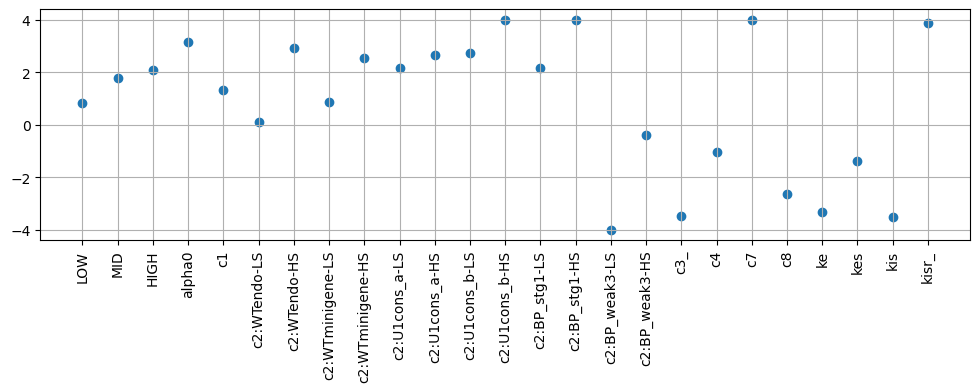

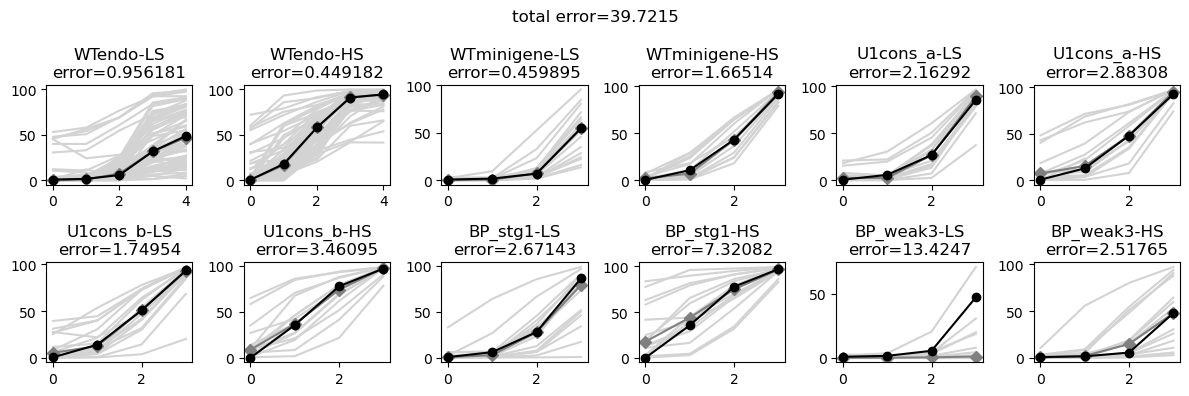

after refinement
fitness 39.54267273292437
0.8214522745251931,1.7591028820092056,2.0783679038274805,2.663704207164104,1.3080846102699664,0.19473623251800362,2.9266973677081816,0.8872631853297159,2.5571635811361677,2.1515498545009466,2.6726523083045173,2.736870575292988,4.0,2.1813165992624493,3.9999999999999987,-4.0,-0.17275960452012692,-3.482661516308166,-1.0527852278120102,3.974728998635711,-2.0705362931920135,-3.320729162636546,-1.3825948236553782,-3.6841191964645024,4.0


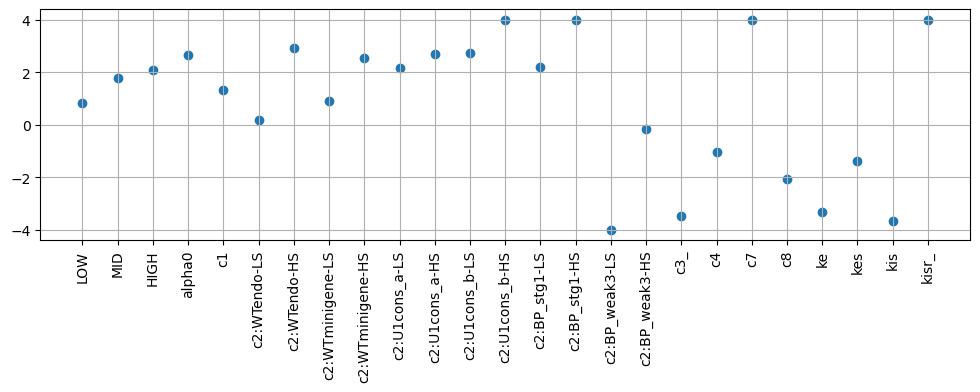

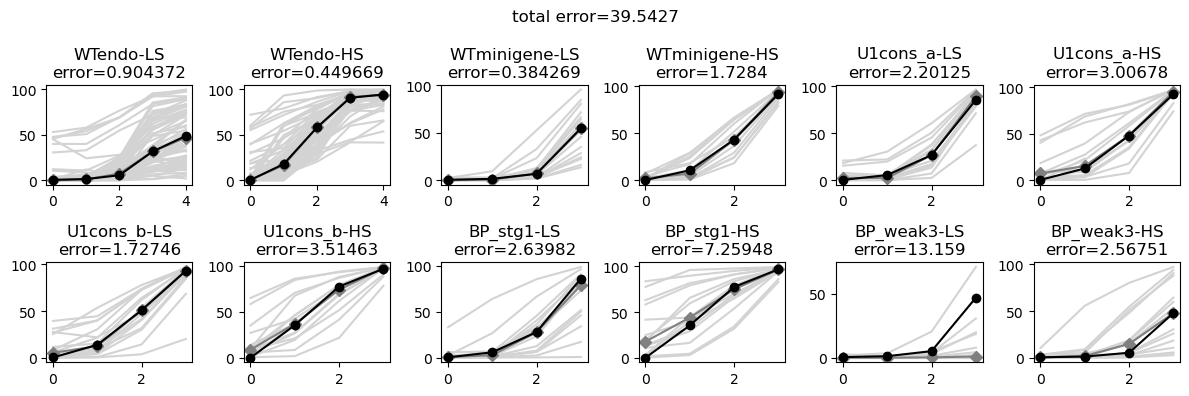

after refinement
fitness 39.7374238912105
0.8214522745251931,1.7591028820092056,2.0783679038274805,3.2036488809220893,1.3080846102699664,0.015934430313154894,2.912694357384234,0.8511969590903862,2.544020300426129,2.138397871460942,2.6593456527350354,2.7234357605465243,4.0,2.1681952852154502,4.0,-4.0,-0.7230341505547596,-3.482661516308166,-1.7993233830410853,3.6264768773392624,-2.0705362931920135,-3.320729162636546,-1.3825948236553782,-3.7563344464060475,3.9865672837005404


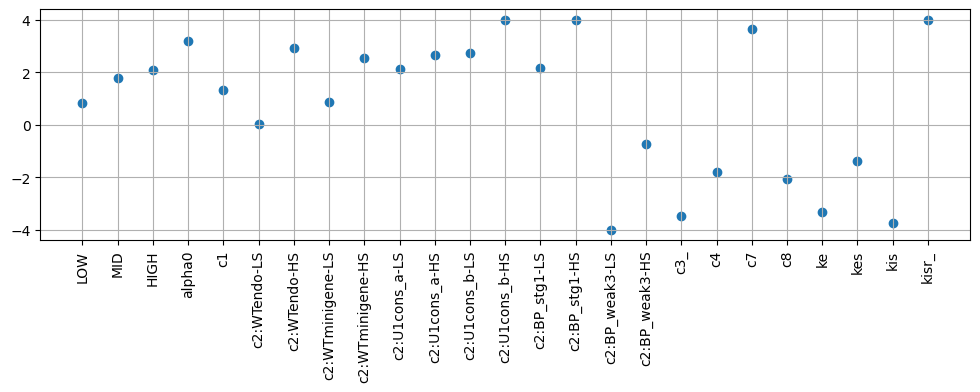

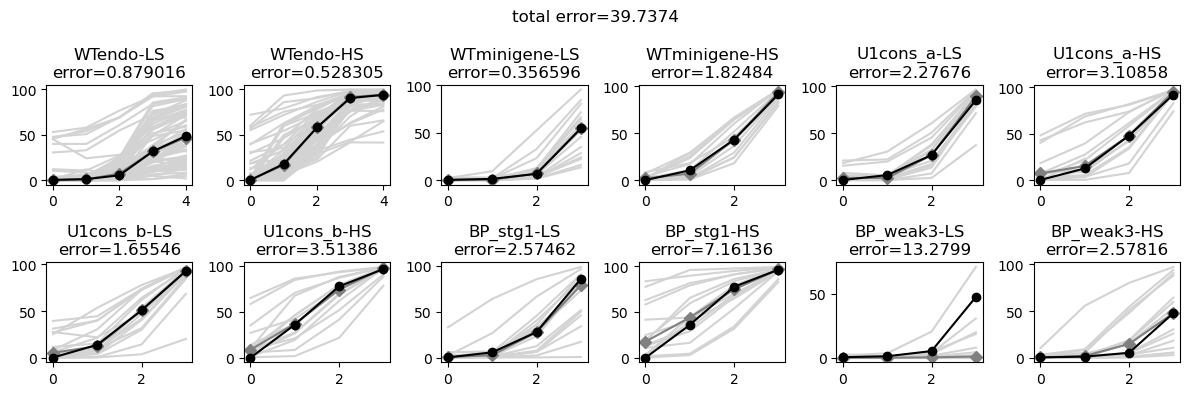

seed 9


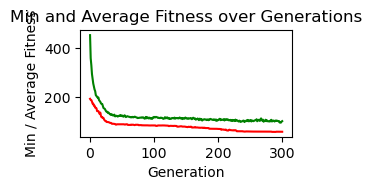

after refinement
fitness 44.692799985160796
1.025268020803444,2.150477840542078,3.0,-1.9190276608865797,-1.15812189167364,2.8330856961000532,-0.8852939507857254,2.5563875805150835,1.2984739847706697,2.046563130853213,-3.327695986664913,-1.470072879496735,-4.0,2.0088106311049,-4.0,4.0,2.6853418076325464,-0.8623182497760175,0.9543677934988407,2.3545705498610077,1.0,-0.08023620602102048,-2.3819292801734924,-1.0691912719059082,3.495998526629685


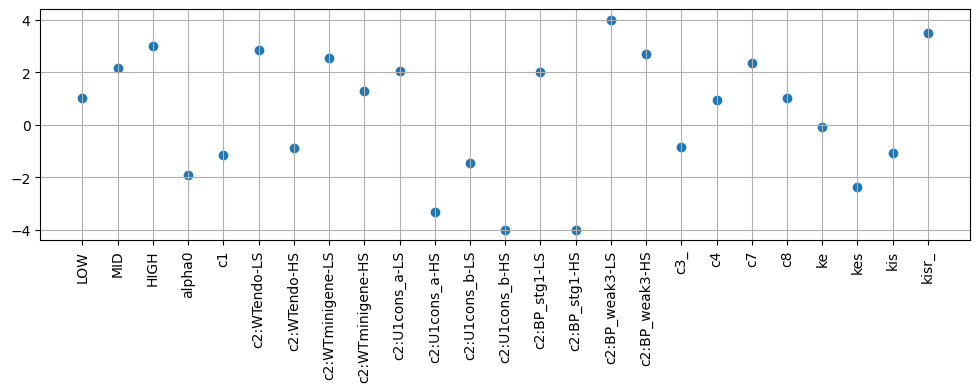

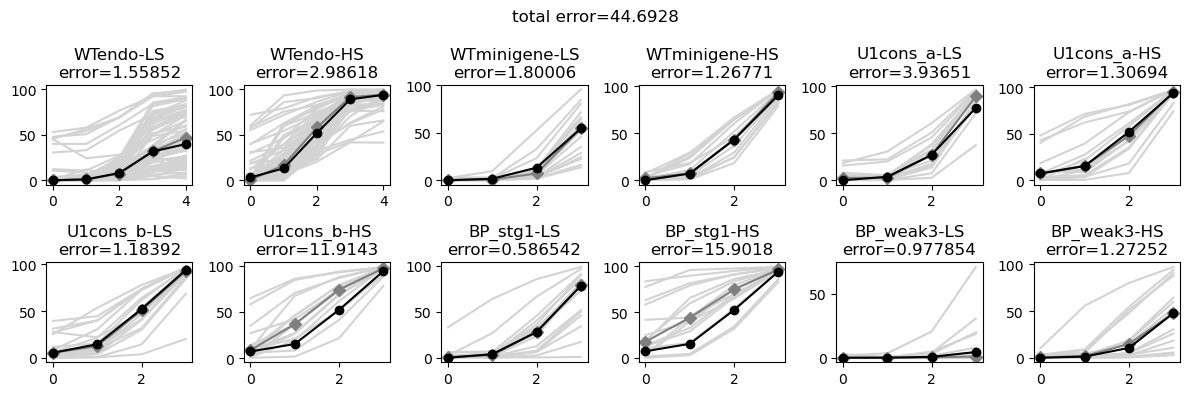

after refinement
fitness 44.67813108544442
1.025268020803444,2.150477840542078,3.0,-1.9190276608865797,-1.15812189167364,2.8280110864931816,-0.8891482977875705,2.5513152301668085,1.2930468613502442,2.0414096229442715,-3.3844453730394073,-1.4758150414792939,-4.0,2.0036496640799215,-4.0,4.0,2.680270430321004,-0.8623182497760175,0.9543677934988407,2.3545705498610077,1.0,-0.08023620602102048,-2.3819292801734924,-1.0742565948190395,3.495998526629685


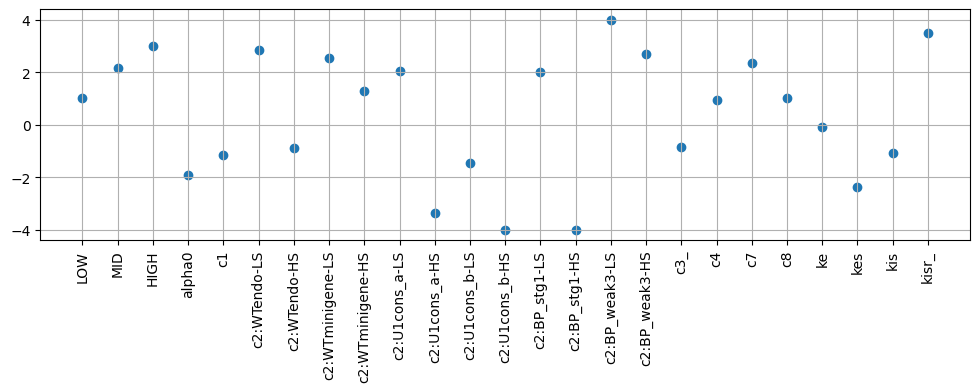

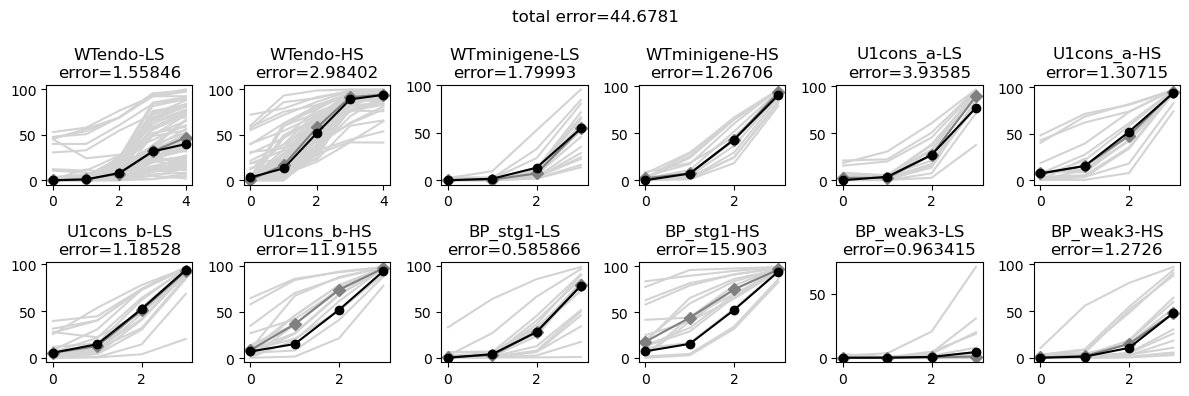

after refinement
fitness 44.98765170835446
1.025268020803444,2.1076389239791404,3.0,-2.2121414517606452,-1.174952065868926,2.85315627629368,-0.8569774711743441,2.5893475976006064,1.4139779115831281,2.1033266402091595,-4.0,-1.566386180718387,-4.0,2.066860275065382,-4.0,4.0,2.7177072081439353,-0.8478405174989044,0.9543677934988407,2.401072749865121,1.0,-0.08023620602102048,-2.218307125510343,-1.0691912719059082,3.495998526629685


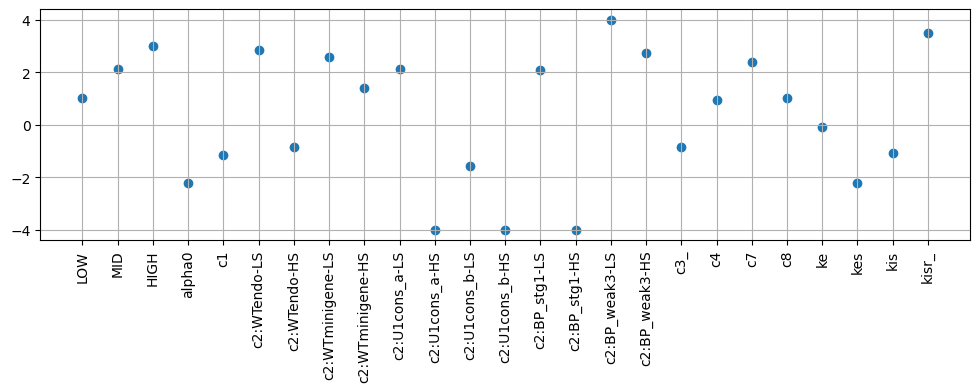

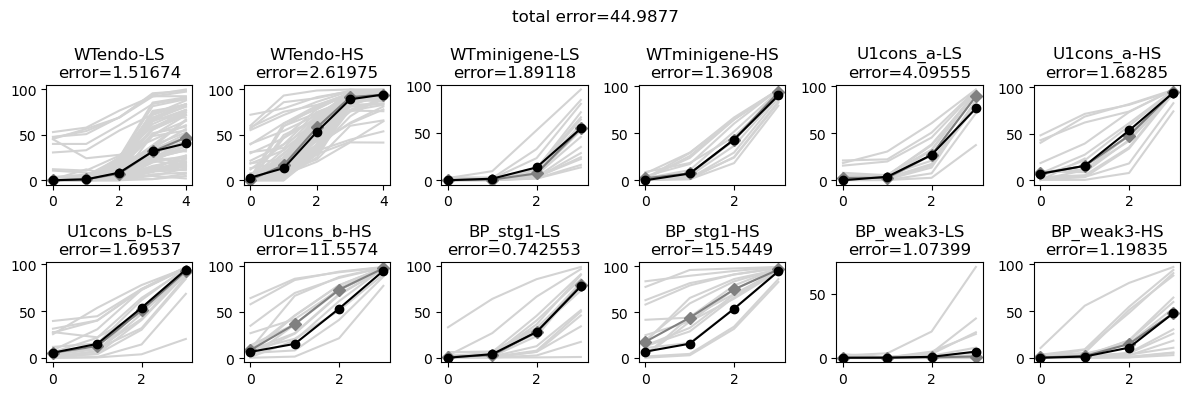

best parameter set
fitness 16.99346176077996 seed [ 1.04383682  2.13921054  2.57779998 -3.04437101 -0.92431512  2.22330755
 -1.5362429   1.96723894 -1.03811979 -0.13181081 -1.20321459 -1.29009087
 -2.40787562  1.20229814 -2.86206963  4.          2.1119742  -2.58373159
 -0.65509515  1.00379545 -1.47549578 -1.51669624 -3.07003958 -3.49681631
  2.66695499]
1.0438368166977046,2.1392105433278683,2.577799976235123,-3.0443710070850334,-0.9243151218856255,2.223307554387115,-1.536242901737313,1.9672389435674635,-1.0381197885259197,-0.13181080664561556,-1.2032145901623064,-1.2900908735186265,-2.4078756167605726,1.202298139803664,-2.862069626050549,4.0,2.111974203618672,-2.583731593999112,-0.6550951519390863,1.0037954498835122,-1.4754957841909293,-1.5166962419301528,-3.0700395824074027,-3.4968163106042933,2.666954994329855


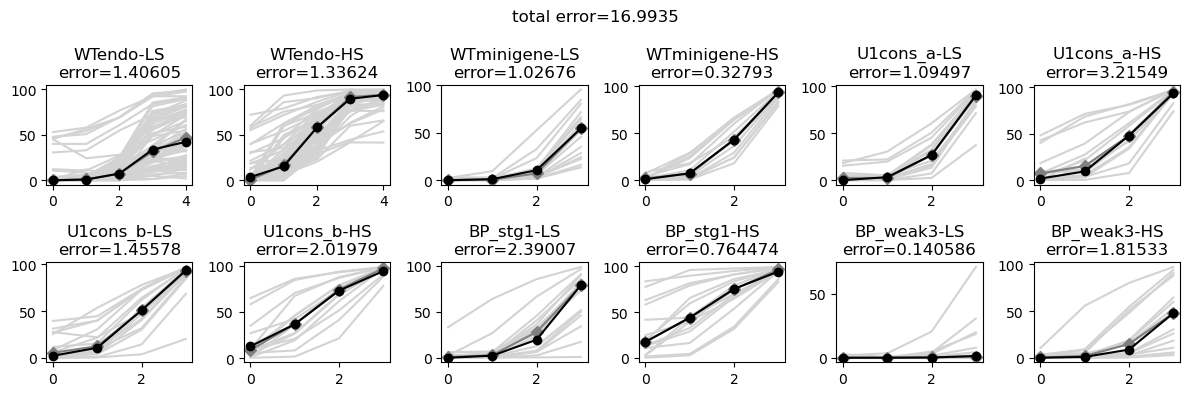

refined? refined
parsetnames LOW,MID,HIGH,alpha0,c1,c2:WTendo-LS,c2:WTendo-HS,c2:WTminigene-LS,c2:WTminigene-HS,c2:U1cons_a-LS,c2:U1cons_a-HS,c2:U1cons_b-LS,c2:U1cons_b-HS,c2:BP_stg1-LS,c2:BP_stg1-HS,c2:BP_weak3-LS,c2:BP_weak3-HS,c3_,c4,c7,c8,ke,kes,kis,kisr_
pars 1.0438368166977046,2.1392105433278683,2.577799976235123,-3.0443710070850334,-0.9243151218856255,2.223307554387115,-1.536242901737313,1.9672389435674635,-1.0381197885259197,-0.13181080664561556,-1.2032145901623064,-1.2900908735186265,-2.4078756167605726,1.202298139803664,-2.862069626050549,4.0,2.111974203618672,-2.583731593999112,-0.6550951519390863,1.0037954498835122,-1.4754957841909293,-1.5166962419301528,-3.0700395824074027,-3.4968163106042933,2.666954994329855


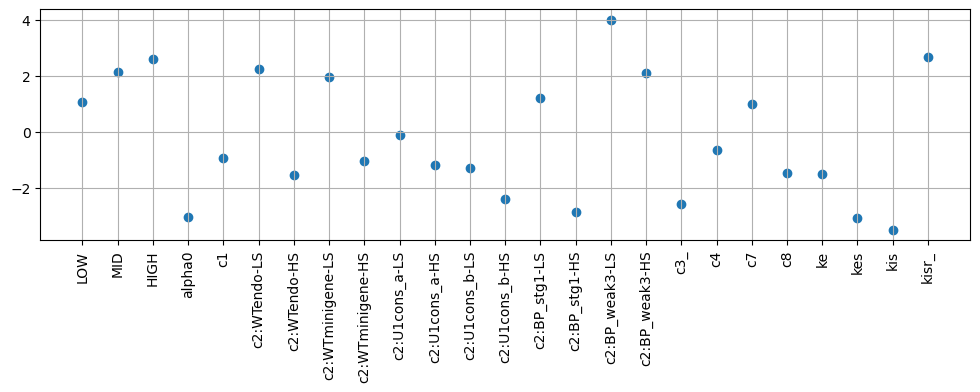

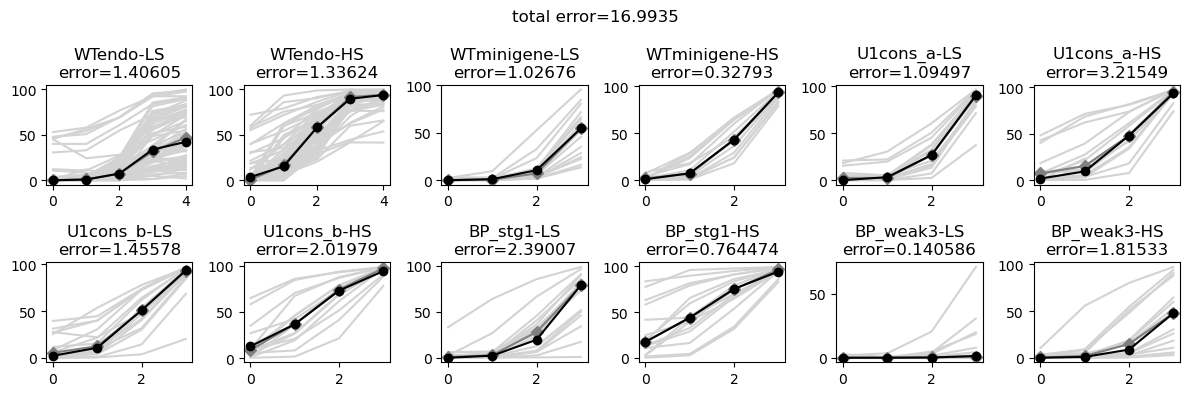

(16.993461760778878,)

In [22]:
best=auxfuncs_fitting.run_genetic(**pars_genetic)
bestpars_perratesdif[ratesdif_str]=best
fitness,parsetnames,pars,seed,refinedbool=best
print("refined?", refinedbool)
print("parsetnames", ",".join(parsetnames))
print("pars",",".join(list(map(str,pars))))

#plot parameter values
fig1,ax=plt.subplots(1,1,figsize=(12,3),sharex=True)
ax.scatter(range(len(pars)),pars)
ax.set_xticks(range(len(pars)))
ax.set_xticklabels(parsetnames,rotation=90)
ax.grid("on")
plt.show()
auxfuncs_fitting.error_and_plot(pars,refined=refinedbool,getparskwargs=getparskwargs,**errorargs_withplotting)

In [ ]:
#copy-paste best result
#refined? refined
#parsetnames LOW,MID,HIGH,alpha0,c1,c2:WTendo-LS,c2:WTendo-HS,c2:WTminigene-LS,c2:WTminigene-HS,c2:U1cons_a-LS,c2:U1cons_a-HS,c2:U1cons_b-LS,c2:U1cons_b-HS,c2:BP_stg1-LS,c2:BP_stg1-HS,c2:BP_weak3-LS,c2:BP_weak3-HS,c3_,c4,c7,c8,ke,kes,kis,kisr_
#pars 0.8705355038530463,1.8736722387573945,2.8636170299287764,-1.715285242964966,-2.7010709706224993,2.812330096641661,-1.137260702221394,2.5055785714206897,-0.5909369809378944,0.9722260085945715,-0.7758239846686671,-0.8710538814055133,-2.3759402866248642,1.6205594888904762,-3.3167070363613917,4.0,2.67388478915785,-1.4286660041538488,0.335900975418894,2.0917752355096626,-1.8541473007802662,-2.0629421529063103,-4.0,-2.0663732333357028,1.561429355790

In [20]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") #there is a deprecation warning appearing
sns.set(style="ticks", context="talk", font_scale=0.5, font="Arial",rc={'figure.figsize':(1,1)})

LOW 7.422248726191617
MID 74.76050713858699
HIGH 730.4946337426991
alpha0 0.01926259337812495
c1 0.0019903480578958256
c2:WTendo-LS 649.1276321689845
c2:WTendo-HS 0.07290197563022735
c2:WTminigene-LS 320.31595494505876
c2:WTminigene-HS 0.25648561874694775
c2:U1cons_a-LS 9.380500449414445
c2:U1cons_a-HS 0.16756218516722263
c2:U1cons_b-LS 0.13456933882015518
c2:U1cons_b-HS 0.00420784480222913
c2:BP_stg1-LS 41.74067701911632
c2:BP_stg1-HS 0.0004822730166173333
c2:BP_weak3-LS 10000.0
c2:BP_weak3-HS 471.93782768271876
c3_ 0.037267820568500615
c4 2.1672098974797036
c7 123.53079474886255
c8 0.01399112701422118
ke 0.008650831383209674
kes 0.0001
kis 0.00858275601113979
kisr_ 36.42749907107974
parsetnames_fixed ['GFP', 'CTR']
parsetnames ['LOW', 'MID', 'HIGH', 'alpha0', 'c1', 'c2:WTendo-LS', 'c2:WTendo-HS', 'c2:WTminigene-LS', 'c2:WTminigene-HS', 'c2:U1cons_a-LS', 'c2:U1cons_a-HS', 'c2:U1cons_b-LS', 'c2:U1cons_b-HS', 'c2:BP_stg1-LS', 'c2:BP_stg1-HS', 'c2:BP_weak3-LS', 'c2:BP_weak3-HS', 'c3_', '

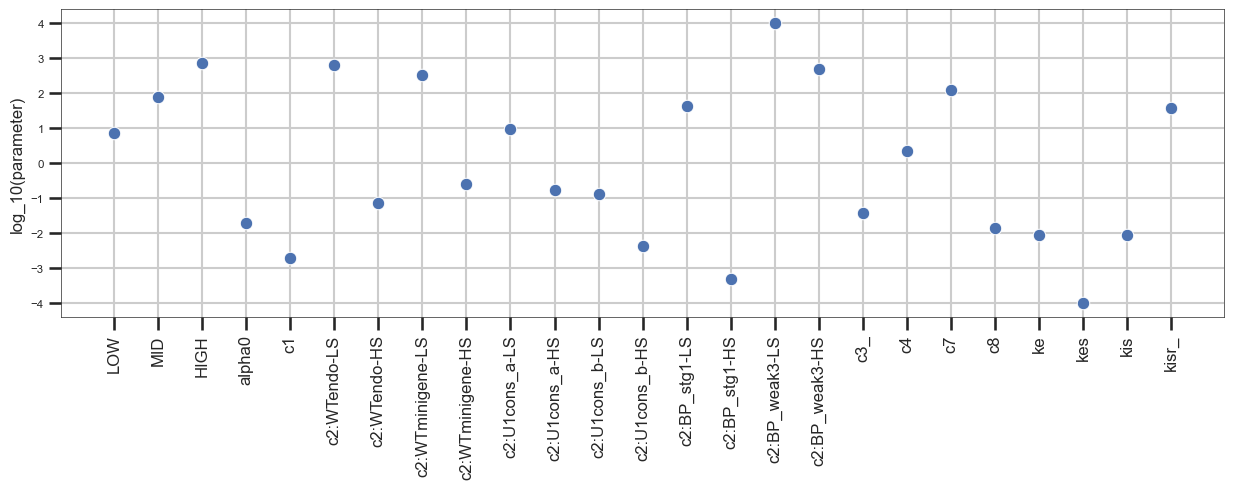

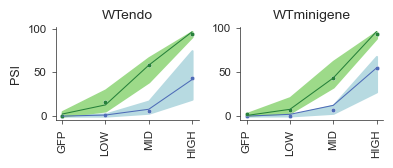

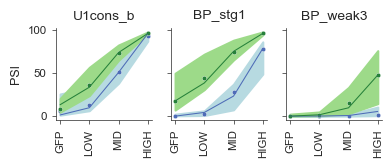

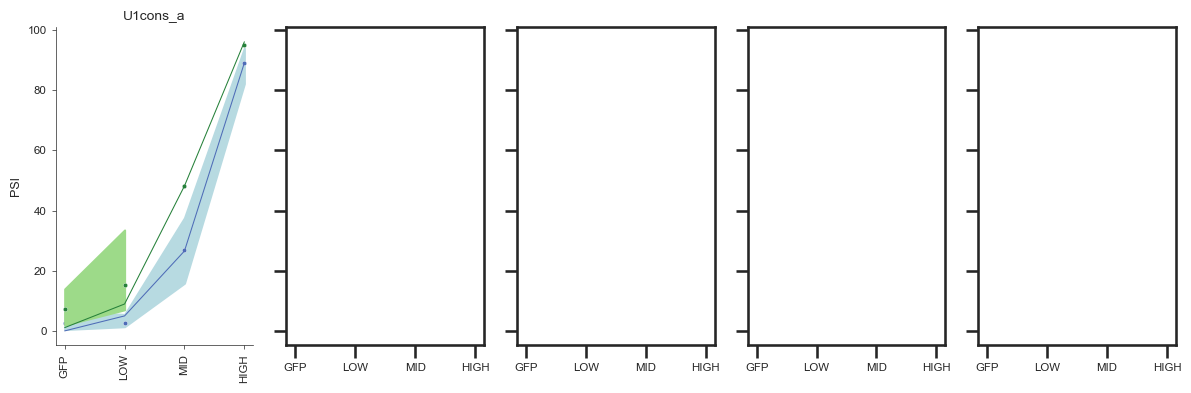

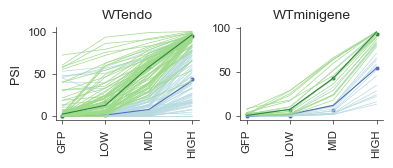

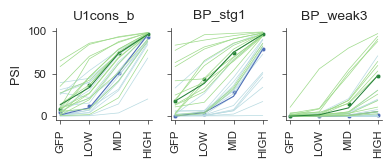

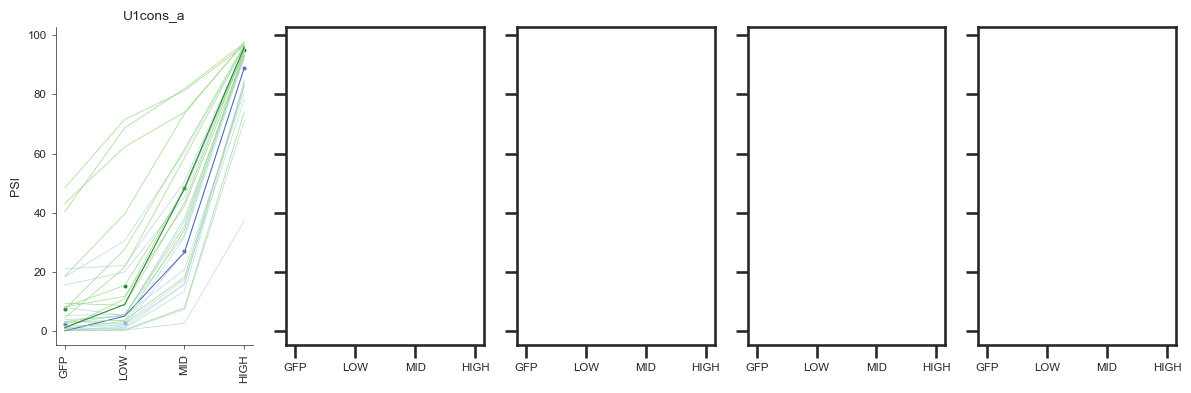

In [29]:
#Copy-paste here the best from above



#allowing kis to change only in a few
parsetnames="LOW,MID,HIGH,alpha0,c1,c2:WTendo-LS,c2:WTendo-HS,c2:WTminigene-LS,c2:WTminigene-HS,c2:U1cons_a-LS,c2:U1cons_a-HS,c2:U1cons_b-LS,c2:U1cons_b-HS,c2:BP_stg1-LS,c2:BP_stg1-HS,c2:BP_weak3-LS,c2:BP_weak3-HS,c3_,c4,c7,c8,ke,kes,kis,kisr_".split(",")
pars=np.array([0.8705355038530463,1.8736722387573945,2.8636170299287764,-1.715285242964966,-2.7010709706224993,2.812330096641661,-1.137260702221394,2.5055785714206897,-0.5909369809378944,0.9722260085945715,-0.7758239846686671,-0.8710538814055133,-2.3759402866248642,1.6205594888904762,-3.3167070363613917,4.0,2.67388478915785,-1.4286660041538488,0.335900975418894,2.0917752355096626,-1.8541473007802662,-2.0629421529063103,-4.0,-2.0663732333357028,1.561429355790])
for i in range(len(parsetnames)):
    print(parsetnames[i],10**pars[i])


data=mediandata
additional_data=[x.values[~np.all(np.isnan(x.values),axis=1)] for x in individual_subdfs]
titles=[x.columns[0].split(":")[0] for x in individual_subdfs]


getparskwargs=auxfuncs_fitting.return_parsdict(groups,inputnames=inputnames_endo,pars_per_group=pars_per_group, pars_per_group_refine=pars_per_group_refine,ratenames=ratenames, minv=minv, maxv=maxv, parranges=parranges,fixedpars=fixedpars)



npars=len(getparskwargs["inputnames"])+len(getparskwargs["ratenames"])
idxsdictname="idxsdict_refine" #these come from refined parameter sets, so c2 and kis change

allparsets=auxfuncs_fitting.get_parameters_per_group(pars,npars=npars,**getparskwargs, **getparskwargs[idxsdictname])
ninput=5
mask_input=getparskwargs["mask_input"]

c=-1
mask_input_endo=[True,True,True,False,True]#remove point as well in this case
#titles

#plot parameter values
fig1,ax=plt.subplots(1,1,figsize=(15,4),sharex=True)
ax=sns.scatterplot(x=range(len(pars)),y=pars)
ax.set_xticks(range(len(pars)))
ax.set_xticklabels(parsetnames,rotation=90,fontsize=12)
ax.spines[['left', 'bottom','right','top']].set_linewidth(.5)
ax.grid("on")
ax.set_ylabel("log_10(parameter)",fontsize=12)
plt.show()

for j in range(2):
    figWT,axesWT=plt.subplots(1,2,figsize=(4,1.75))
    figmut,axesmut=plt.subplots(1,3,figsize=(4,1.75),sharex=True, sharey=True)
    figrest,axesrest=plt.subplots(1,5, figsize=(12,4),sharex=True,sharey=True)
    axesrest=axesrest.flatten()
    i=0
    i_=0
    for g in range(len(allparsets)):
        label=titles[g]
        xvec_psi=allparsets[g,0:ninput][mask_input[g]]
        #print(xvec_psi)
        #range_n=np.where(mask_input[g])[0]
        #range_n=np.arange(4)

        rates=allparsets[g,ninput:]
        model_g=auxfuncs_fitting.out_event(rates,xvec_psi,solve_linear_system=sysfunc)
        data_g=data[g] #trend (median)
        data_g_a=additional_data[g]
        if "endo" in label:
            #remove 4th point, which is not present in the rest
            model_g=model_g[mask_input_endo]
            data_g=data_g[mask_input_endo]
            data_g_a=data_g_a[:None,mask_input_endo]
        #print(model_i)
        if g<2:
            ax=axesWT[0]
        elif g<4:
            ax=axesWT[1]
        elif label.strip("-LS").strip("-HS") in ["U1cons_b","BP_stg1","BP_weak3"]:
            ax=axesmut[i_]
            if "HS" in label:
                i_+=1
        else:
            ax=axesrest[i]
            if "HS" in label or "CS" in label:
                i+=1

        
        q25=np.quantile(data_g_a,0.25,axis=0)
        q75=np.quantile(data_g_a,0.75,axis=0)
        range_n=np.arange(len(model_g))
        if "LS" in label:
            color="#4e6cb7ff"
            fillcolor="#b7dae1ff"
        else:
            color="#26813aff"
            fillcolor="#9dda89ff"
        if j==0: 
            ax.fill_between(range_n,q25,q75,color=fillcolor)
            ax = sns.scatterplot(x=range_n,y=data_g,color=color,marker="o",s=10,ax=ax)
            ax = sns.lineplot(x=range_n, y=model_g, linewidth = .75,color=color,ax=ax)
            #ax.plot(range_n,model_g,color=color)
        else:
            for l in range(len(data_g_a)):
                data_l=data_g_a[l]
                if np.all(~np.isnan(data_l)):
                    ax = sns.lineplot(x=range_n,y=data_l,color=fillcolor,ax=ax,linewidth=0.5)
            ax=sns.scatterplot(x=range_n,y=data_g,color=color,marker="o",s=10,ax=ax)
            ax=sns.lineplot(x=range_n,y=model_g,color=color,ax=ax,linewidth = .75)
        ax.spines[['left', 'bottom']].set_linewidth(.5)
        ax.spines[['right', 'top']].set_linewidth(0)
        ax.xaxis.set_tick_params(width=0.5, length=3)
        ax.yaxis.set_tick_params(width=0.5, length=3)

        #ax.legend()
        #ax.set_xticks()
        ax.set_title(titles[g].strip("-HS").strip("-LS").replace(";","\n"),fontsize=10)
        ax.set_xticks(range(4))
        ax.set_xticklabels(["GFP","LOW","MID","HIGH"],rotation=90)
    axesWT[0].set_ylabel("PSI")
    axesmut[0].set_ylabel("PSI")
    axesrest[0].set_ylabel("PSI")
    #axesrest[7].set_ylabel("PSI")
    figWT.tight_layout()
    figWT.savefig("./panels/WT_%d.pdf"%j)
    figWT.savefig("./panels/WT_%d.svg"%j)
    figmut.tight_layout()
    figmut.savefig("./panels/figmut_%d.pdf"%j)
    figmut.savefig("./panels/figmut_%d.svg"%j)
    figrest.tight_layout()
    figmut.savefig("./panels/figrest_%d.pdf"%j)
    plt.show()

# Fit the individual events. 

In [23]:
from scipy.stats import linregress
import copy

In [24]:
#do it twice, the second time also allowing kis to change
print(pars_per_group)
pars_per_group_individual=[copy.deepcopy(pars_per_group),copy.deepcopy(pars_per_group)]
print(pars_per_group_individual)

[['c2:WTendo-LS'], ['c2:WTendo-HS'], ['c2:WTminigene-LS'], ['c2:WTminigene-HS'], ['c2:U1cons_a-LS'], ['c2:U1cons_a-HS'], ['c2:U1cons_b-LS'], ['c2:U1cons_b-HS'], ['c2:BP_stg1-LS'], ['c2:BP_stg1-HS'], ['c2:BP_weak3-LS'], ['c2:BP_weak3-HS']]
[[['c2:WTendo-LS'], ['c2:WTendo-HS'], ['c2:WTminigene-LS'], ['c2:WTminigene-HS'], ['c2:U1cons_a-LS'], ['c2:U1cons_a-HS'], ['c2:U1cons_b-LS'], ['c2:U1cons_b-HS'], ['c2:BP_stg1-LS'], ['c2:BP_stg1-HS'], ['c2:BP_weak3-LS'], ['c2:BP_weak3-HS']], [['c2:WTendo-LS'], ['c2:WTendo-HS'], ['c2:WTminigene-LS'], ['c2:WTminigene-HS'], ['c2:U1cons_a-LS'], ['c2:U1cons_a-HS'], ['c2:U1cons_b-LS'], ['c2:U1cons_b-HS'], ['c2:BP_stg1-LS'], ['c2:BP_stg1-HS'], ['c2:BP_weak3-LS'], ['c2:BP_weak3-HS']]]


In [25]:
ratenames

['alpha0', 'c1', 'c2', 'c3_', 'c4', 'c7', 'c8', 'ke', 'kes', 'kis', 'kisr_']

In [29]:
ninput

5

rates_group ['c2', 'kis']
idxs_rates_group [7, 14]
rates_group ['c2', 'kis']
idxs_rates_group [7, 14]
rates_group ['c2', 'kis']
idxs_rates_group [7, 14]
rates_group ['c2', 'kis']
idxs_rates_group [7, 14]
rates_group ['c2', 'kis']
idxs_rates_group [7, 14]
rates_group ['c2', 'kis']
idxs_rates_group [7, 14]
rates_group ['c2', 'kis']
idxs_rates_group [7, 14]
rates_group ['c2', 'kis']
idxs_rates_group [7, 14]
rates_group ['c2', 'kis']
idxs_rates_group [7, 14]
rates_group ['c2', 'kis']
idxs_rates_group [7, 14]
rates_group ['c2', 'kis']
idxs_rates_group [7, 14]
rates_group ['c2', 'kis']
idxs_rates_group [7, 14]


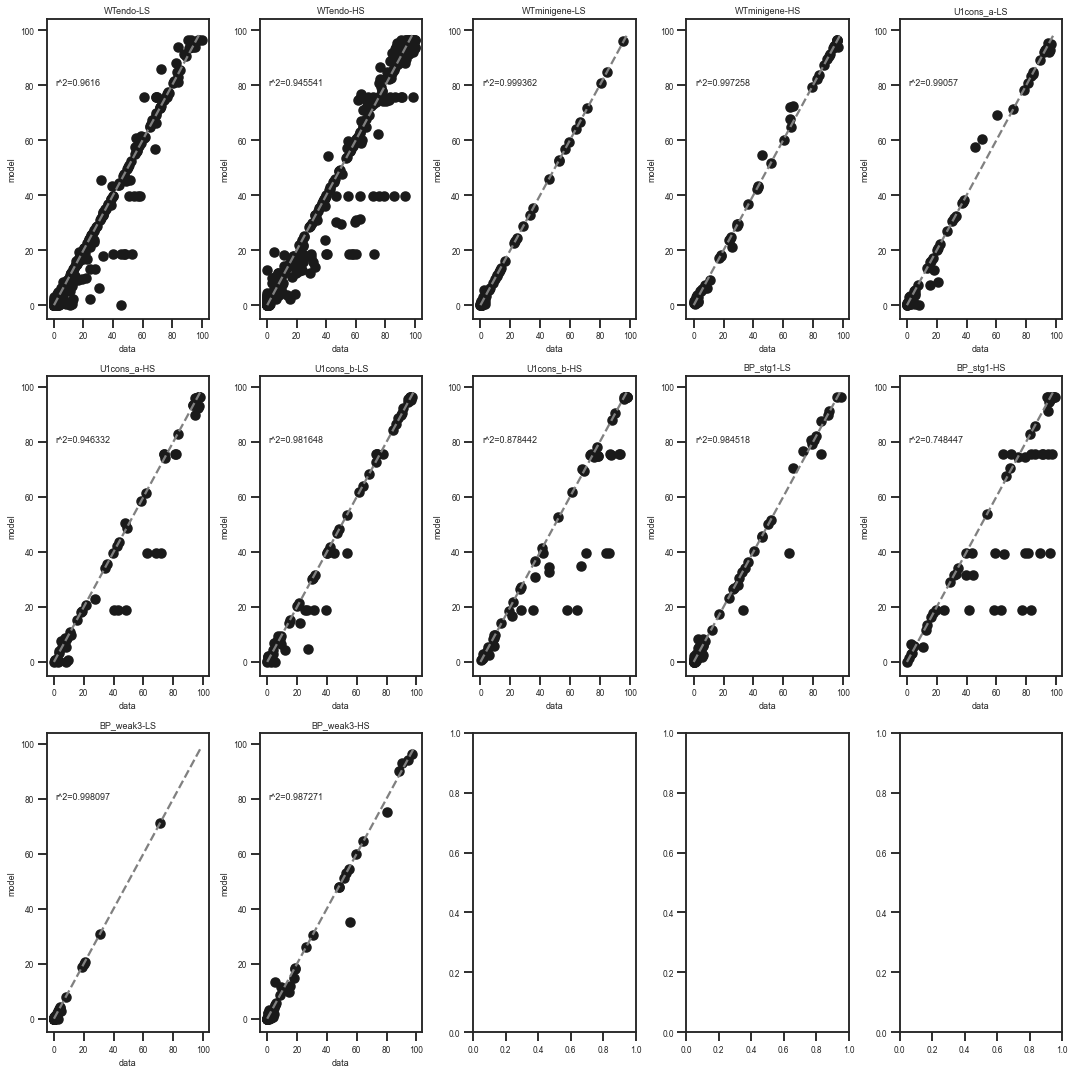

In [34]:
#keep the exon-specific parameters within these bounds.
#allow bigger changes since the c2 is at the limit for a few cases
refined = True
minv=-6
maxv=6
sysfunc=errorargs["sysfunc"]
titles=errorargs_withplotting["plotkwargs"]["titles"]
npars=len(getparskwargs["inputnames"])+len(getparskwargs["ratenames"])

ratenames=getparskwargs["ratenames"]
    
mask_input=getparskwargs["mask_input"]
ninput=5
if refined:
    idxsdict=getparskwargs["idxsdict_refine"]
else:
    idxsdict=getparskwargs["idxsdict_global"]
allparsets=auxfuncs_fitting.get_parameters_per_group(best[2],npars=npars,**getparskwargs,**idxsdict)


                           

eventspecific_parsets_pergroup=[]
for g in range(ngroups):
    parset_g=allparsets[g]
    xvec_psi=parset_g[0:ninput][mask_input[g]]
    range_n=np.arange(len(xvec_psi))
    rates=allparsets[g,ninput:]
    median_model=auxfuncs_fitting.out_event(rates,xvec_psi,solve_linear_system=sysfunc)
    median_data=mediandata[g]

    reference_parset=parset_g.copy()
    #print("reference_parset", reference_parset)
    #rates_group=[x.split(":")[0] for x in pars_per_group_refine[g]]
    rates_group=["c2","kis"] #allow a change in both, improves the fit to some BP_stg1 that have very high PSI
    idxs_rates_group=[ratenames.index(x)+ninput for x in rates_group]
    print("rates_group", rates_group)
    print("idxs_rates_group", idxs_rates_group)

    allparsets_optim_events=[] 
    x0=np.log10(reference_parset[idxs_rates_group])
    events=errorargs_withplotting["additional_data"][g]
    eventspecific_parsets=[]
    for enum in range(len(events)):
        data_event=events[enum]
        minfunc=partial(auxfuncs_fitting.error_refine_singlegroup,data=data_event,idxs_pars=idxs_rates_group, reference_parset=reference_parset, mask_input=mask_input[g],errorfunc=errorargs["errorfunc"], sysfunc=sysfunc)
        #print("initial error", minfunc(x0))
        initial_conditions=[x0]
        for i in range(100):
            np.random.seed(i)
            initial_conditions.append([np.random.uniform(minv,maxv) for rate in rates_group])
        optimscores=[]
        optimpars=[]
        for x0 in initial_conditions:
            out=minimize(minfunc,x0,bounds=[[minv,maxv] for rate in rates_group],method="L-BFGS-B")
            optimscores.append(out.fun)
            optimpars.append(out.x)
        bestidx=np.argsort(optimscores)[0]
        bestpars_e=optimpars[bestidx]
        #print("bestidx", bestidx, optimscores[bestidx])

        optim_parset=reference_parset.copy()
        optim_parset[idxs_rates_group]=10**bestpars_e
        eventspecific_parsets.append(optim_parset)
    eventspecific_parsets_pergroup.append(eventspecific_parsets)


#now plot results
fig,axes=plt.subplots(3,5,figsize=(3*5,3*5))
axes=axes.flatten()
xticks=np.arange(len(xvec_psi))

for g in range(ngroups):
    eventspecific_parsets=eventspecific_parsets_pergroup[g]
    events=errorargs_withplotting["additional_data"][g]
    ax=axes[g]

    ax.set_xlabel("data")
    ax.set_ylabel("model")
    ax.plot(range(100),range(100),color="gray",linestyle="--")
    ax.set_title(titles[g])
    allx=[]
    ally=[]

    for enum in range(len(eventspecific_parsets)):
        parset=eventspecific_parsets[enum]
        data_event=events[enum]
        if not np.any(np.isnan(data_event)):
            xvec_psi=parset[0:ninput][mask_input[g]]
            rates=parset[ninput:]
            model=auxfuncs_fitting.out_event(rates,xvec_psi,solve_linear_system=sysfunc)
            #ax.scatter(data_event,model,color="b")
            allx.extend(list(data_event))
            ally.extend(list(model))
    ax.scatter(allx,ally,color="k")
    slope, intercept, r_value, p_value, std_err = linregress(allx, ally)
    ax.text(1,80,"r^2=%g"%(r_value)**2)

    if False:
        plt.scatter(xticks,median_data,color="blue")
        plt.plot(xticks,median_model,color="blue")
        plt.plot(range(len(xvec_psi)),data_event,color="gray",marker="D")
        plt.plot(range(len(xvec_psi)),model,color="k")
        plt.show()
plt.tight_layout()
plt.show()

In [39]:
allparsets


array([[0.00000000e+00, 1.00000000e+00, 7.28440661e+00, 6.10591726e+02,
        1.00000000e+03, 8.69349132e-04, 1.00000000e+04, 5.22772679e+01,
        1.36226099e-02, 2.08696693e-02, 9.25840653e+01, 2.28935977e+00,
        5.41680333e+02, 1.00000000e-04, 1.99196273e-03, 4.50848461e+01],
       [0.00000000e+00, 1.00000000e+00, 7.28440661e+00, 6.10591726e+02,
        1.00000000e+03, 8.69349132e-04, 1.00000000e+04, 9.75744784e-01,
        1.36226099e-02, 2.08696693e-02, 9.25840653e+01, 2.28935977e+00,
        5.41680333e+02, 1.00000000e-04, 1.99196273e-03, 4.50848461e+01],
       [0.00000000e+00, 1.00000000e+00, 7.28440661e+00, 6.10591726e+02,
        1.00000000e+03, 8.69349132e-04, 1.00000000e+04, 3.41915429e+01,
        1.36226099e-02, 2.08696693e-02, 9.25840653e+01, 2.28935977e+00,
        5.41680333e+02, 1.00000000e-04, 1.99196273e-03, 4.50848461e+01],
       [0.00000000e+00, 1.00000000e+00, 7.28440661e+00, 6.10591726e+02,
        1.00000000e+03, 8.69349132e-04, 1.00000000e+04, 1.826